## Investigative 13549

11-15-2023

In [1]:
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw as afw 
import numpy as np 
import matplotlib.pyplot as plt
import pickle as pkl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from operator import add
import statistics 
import random 
import os

In [2]:
! eups list -s lsst_distrib

   ge942eb05b2+0a94523d54 	current w_2024_37 setup


In [20]:
exposureTimes = [110.0, 169.4, 61.6, 149.6, 77.0, 114.4, 154.0, 107.8, 158.4, 
             72.6, 156.2, 2.2, 39.6, 103.4, 0, 37.4, 96.8, 81.4, 17.6, 165.0, 
             101.2, 94.6, 22, 134.2, 129.8, 88.0, 57.2, 63.8,  123.2, 85.8, 145.2, 
             35.2, 8.8, 121.0, 151.8, 74.8, 50.6, 30.8, 140.8, 26.4, 105.6, 127.6, 138.6, 
             79.2, 112.2, 48.4, 11.0, 44.0, 52.8, 15.4, 83.6, 160.6, 132.0, 90.2, 13.2, 
             28.6, 46.2, 55.0, 66.0, 162.8, 68.2, 59.4, 118.8, 99.0, 125.4, 136.4, 24.2, 
             33.0, 92.4, 4.4, 70.4, 41.8, 147.4, 167.2, 116.6, 19.8, 143.0, 6.6]

# find "low peaK" 
indexes = [index for index, value in enumerate(exposureTimes) if value > 111]
print(indexes)

print(len(indexes))

vals = [0, 2, 6, 7, 14, 18, 19, 20, 21, 22, 25, 26, 29, 30, 34, 36, 39, 42, 48, 51, 55, 
         56, 61, 65, 69, 75, 76, 81, 83, 87, 92, 95, 98, 101, 105, 110, 117, 123, 124, 127, 
        128, 142, 144, 145, 148, 149, 153, 154, 155, 159, 160, 163, 164, 167, 177, 178, 180, 
        182, 183, 186, 187, 192, 195, 197, 201, 202, 204, 211, 212, 216, 217, 220, 225, 226, 228, 229, 231, 233]

print(len(vals))
print(len(vals)/3)

[1, 3, 5, 6, 8, 10, 19, 23, 24, 28, 30, 33, 34, 38, 41, 42, 44, 51, 52, 59, 62, 64, 65, 72, 73, 74, 76]
27
78
26.0


## Not trimmed (overscan pixels)

In [2]:
def defineCountsBins(datarefs, amps_list, ampNames, butler): #write a function that iterates over all the images 
    bins = np.arange(2e4, 2e5)
    countsdict = {} 
    
    ## CHANGE TO ALL DATAREFS FOR ALL IMAGES
    for dataref in datarefs[:2]:
        exp = butler.get(dataref) 
        det = exp.getDetector()
        trimmed_ims = [exp.getMaskedImage()[amp.getRawDataBBox()].getImage() for amp in det if amp.getName() in amps_list]
        im_arrs = [trimmed_im.getArray().flatten().astype(int) for trimmed_im in trimmed_ims]
        comp_hist = {ampName: np.histogram(im_arrs, bins=bins)[0] for ampName, im_arrs in zip(ampNames, im_arrs)} 
        if len(countsdict) == 0: 
            countsdict = comp_hist
        else: 
            for key in countsdict: 
                countsdict[key] = list(map(add, countsdict[key], comp_hist[key]))
    return countsdict, bins

def getButler(runnum, rtype, detectornum):
    #repo_path = "/repo/ir2"
    repo_path = "/sdf/group/rubin/repo/main" #the repo path has changed to access these older images... 

    butler = Butler(repo_path, collections=['LSSTCam/photodiode','LSSTCam/raw/all'], instrument='LSSTCam')
    registry = butler.registry
    recordClasses = butler.registry.queryDimensionRecords('detector', where="instrument='LSSTCam'")
    det_raft_pairs = sorted([(rc.id, rc.full_name) for rc in recordClasses])    
    
    ## get Datarefs 
    where = f"exposure.science_program='{runnum}' and exposure.observation_type ='{rtype}'"
    collections = 'LSSTCam/raw/all'
    dataId = {'detector': detectornum}
    datarefs = list(butler.registry.queryDatasets(datasetType='raw', collections=collections, where=where, dataId=dataId))
    exp = butler.get(datarefs[0]) #use just the first image : ) 
    det = exp.getDetector()
    amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    ampNames = [amp.getName() for amp in det if amp.getName() in amps_list] #the order in which the channels are in the dataset 

    #bins = np.arange(2e4, 2e5)
    for dataref in datarefs[:1]:
        exp = butler.get(dataref) 
        det = exp.getDetector()
        trimmed_ims = [exp.getMaskedImage()[amp.getRawDataBBox()].getImage() for amp in det if amp.getName() in amps_list]
        im_arrs = [trimmed_im.getArray().flatten().astype(int) for trimmed_im in trimmed_ims]
        plt.imshow(exp.image.array)
        plt.title(f"ramp run 13549, detector {detectornum} single exposure")
        plt.colorbar()
        plt.show()


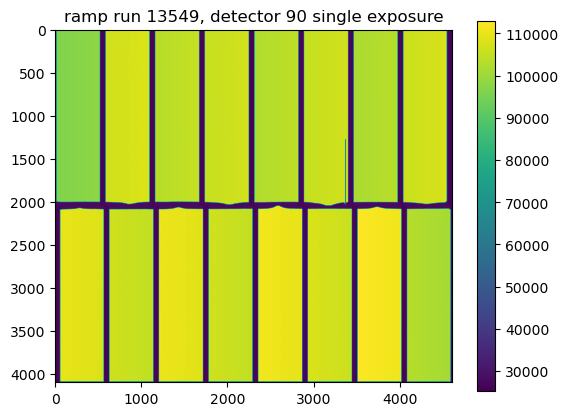

In [12]:
butler = getButler(13549, 'ramp', 90)

## Individual with overscan

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def getButler2(runnum, rtype, detectornum):
    repo_path = "/repo/ir2"
    butler = Butler(repo_path, collections=['LSSTCam/photodiode','LSSTCam/raw/all'], instrument='LSSTCam')
    registry = butler.registry
    recordClasses = butler.registry.queryDimensionRecords('detector', where="instrument='LSSTCam'")
    det_raft_pairs = sorted([(rc.id, rc.full_name) for rc in recordClasses])    
    
    ## get Datarefs 
    where = f"exposure.science_program='{runnum}' and exposure.observation_type ='{rtype}'"
    collections = 'LSSTCam/raw/all'
    dataId = {'detector': detectornum}
    datarefs = list(butler.registry.queryDatasets(datasetType='raw', collections=collections, where=where, dataId=dataId))
    exp = butler.get(datarefs[0]) #use just the first image : ) 
    det = exp.getDetector()
    amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    ampNames = [amp.getName() for amp in det if amp.getName() in amps_list] #the order in which the channels are in the dataset 

    #bins = np.arange(2e4, 2e5)
    for dataref in datarefs[:1]:
        
        fig, axes = plt.subplots(2, 8,figsize=(20,12))
        for i, amp in enumerate(det):
            ax = axes[i//8, i%8]
            amp_im_arr = exp[amp.getRawBBox()].image.array # pull out the numpy array

            #clim=np.percentile(amp_im_arr.flat, (2,98)) # find some reasonable bounds to color-clip the plot
                                                # and avoid outliers obscuring the structure
            
            #pltim = ax.imshow(amp_im_arr, clim=clim, vmin=107000, vmax=110000)
            #pltim = ax.imshow(amp_im_arr, clim=clim, vmin=20000, vmax=50000)
            pltim = ax.imshow(amp_im_arr, vmin=20000, vmax=120000)

            ax.set_title(amp.getName()) # show each amp's name above its image
    
            divider = make_axes_locatable(ax)
            cax = divider.new_horizontal(size="10%", pad=0.2)
            fig.add_axes(cax)
            fig.colorbar(pltim, cax=cax, orientation="vertical")

            xax = ax.get_xaxis().set_visible(False)

            yax = ax.get_yaxis().set_visible(False)
    
        plt.suptitle(f'Run {runnum}');
        plt.tight_layout()
        plt.show()

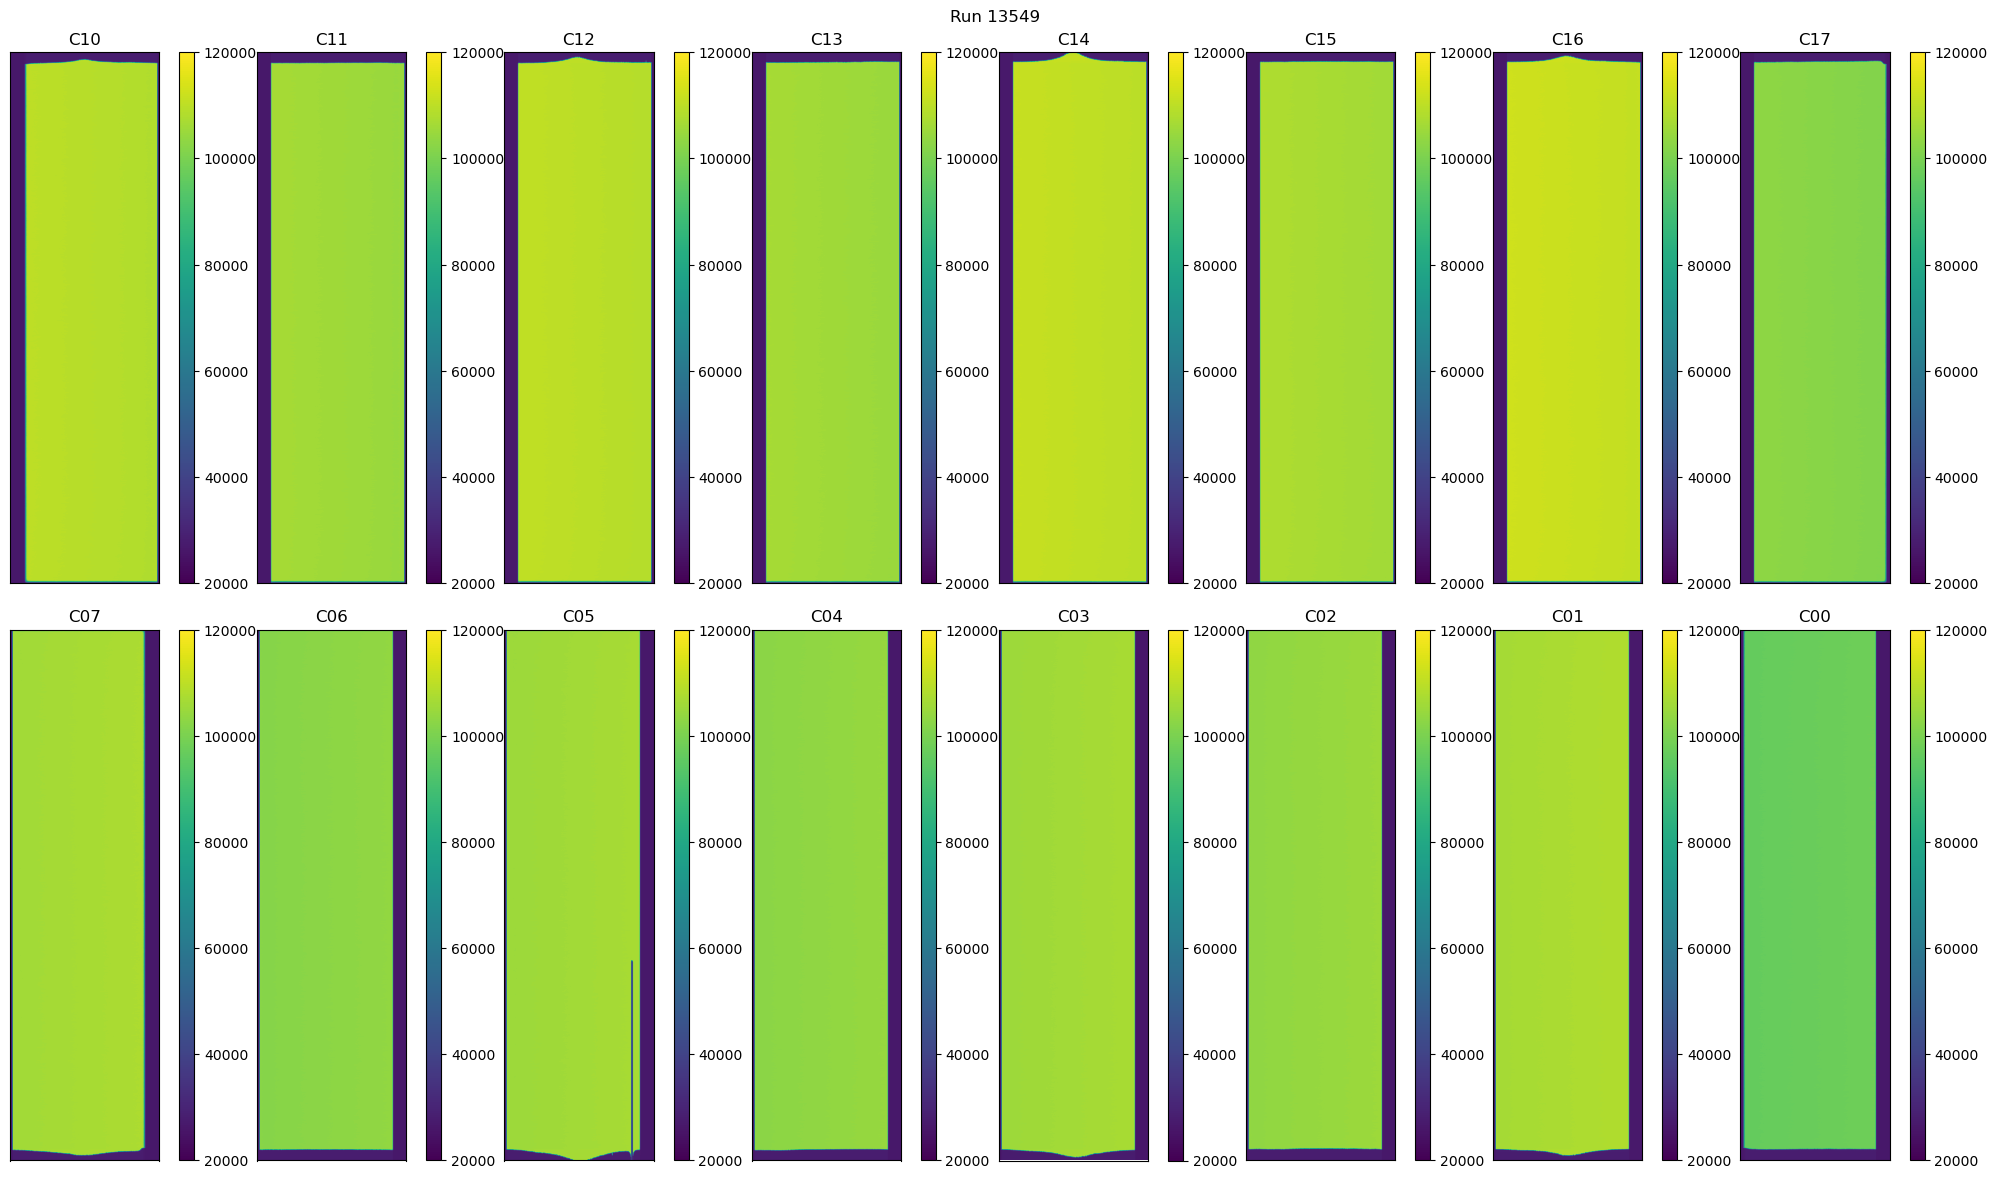

In [18]:
getButler2(13549, 'ramp', 90)

## compare to the method to build histograms 

In [3]:
def convertSensorName(sensorname): ## this function takes the detector number and spits out the raft/sensor name RXXSXX format
    repo_path = "/repo/ir2"
    butler = Butler(repo_path, collections=['LSSTCam/photodiode','LSSTCam/raw/all'], instrument='LSSTCam')
    registry = butler.registry
    recordClasses = butler.registry.queryDimensionRecords('detector', where="instrument='LSSTCam'")
    det_raft_pairs = sorted([(rc.id, rc.full_name) for rc in recordClasses])
    for [a,b] in  det_raft_pairs:
        if b == sensorname: 
            detectornumber = a 
    return detectornumber 

def getDatarefs(butler, detectornum, runnum, rtype, amplifier): # gets the Datarefs 
    where = f"exposure.science_program='{runnum}' and exposure.observation_type ='{rtype}'"
    collections = 'LSSTCam/raw/all'
    dataId = {'detector': detectornum}
    datarefs = list(butler.registry.queryDatasets(datasetType='raw', collections=collections, where=where, dataId=dataId))
    exp = butler.get(datarefs[0]) #use just the first image to get the order of amps
    det = exp.getDetector()
    
    amps_list = [amplifier] 
    #amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    ampNames = [amp.getName() for amp in det if amp.getName() in amps_list] #the order in which the channels are in the dataset 
    return datarefs, amps_list, ampNames

def defineCountsBins(datarefs, amps_list, ampNames, butler, start, end): #write a function that iterates over all the images 
    bins = np.arange(2e4, 2e5)
    countsdict = {} 
    ## CHANGE TO ALL DATAREFS FOR ALL IMAGES
    for dataref in datarefs[start:end]:
        exp = butler.get(dataref) 
        det = exp.getDetector()
        trimmed_ims = [exp.getMaskedImage()[amp.getRawDataBBox()].getImage() for amp in det if amp.getName() in amps_list]
        im_arrs = [trimmed_im.getArray().flatten().astype(int) for trimmed_im in trimmed_ims]
        comp_hist = {ampName: np.histogram(im_arrs, bins=bins)[0] for ampName, im_arrs in zip(ampNames, im_arrs)} 
        
        if len(countsdict) == 0: 
            countsdict = comp_hist
        else: 
            for key in countsdict: 
                countsdict[key] = list(map(add, countsdict[key], comp_hist[key]))
    return countsdict, bins

def runAllExp13549(detectornum, butler, amplifier, start, end): #write this function afterwards 
    datarefs, amps_list, ampNames = getDatarefs(butler, detectornum, 13549, 'ramp', amplifier)
    countsdict, bins = defineCountsBins(datarefs, amps_list, ampNames, butler, start, end)
    
    return countsdict, bins


def defineSensorAttributes(amplifier, detectornum, start, end): 
    repo_path = "/repo/ir2"
    butler = Butler(repo_path, collections=['LSSTCam/photodiode','LSSTCam/raw/all'], instrument='LSSTCam')
    registry = butler.registry
    recordClasses = butler.registry.queryDimensionRecords('detector', where="instrument='LSSTCam'")
    det_raft_pairs = sorted([(rc.id, rc.full_name) for rc in recordClasses])
    sensorname = det_raft_pairs[detectornum][1]
    
    countsdict, bins = runAllExp13549(detectornum, butler, amplifier, start, end)
    print("finished 13549")

    return countsdict, bins

finished 13549


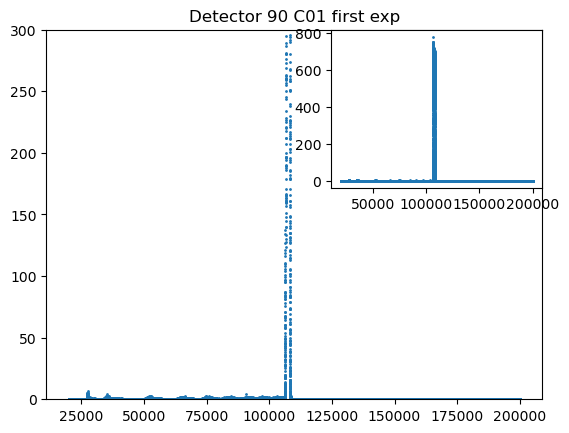

In [11]:
amp = 'C01'
countsdict, bins = defineSensorAttributes(amp, 90, 0, 1) 
counts = countsdict[amp]

# Create the main figure and axes
fig, ax = plt.subplots()
ax.scatter(bins[:len(counts)], counts, s=1)
ax.set_title(f"Detector 90 {amp} first exp")
ax.set_ylim(0, 300)

# Add an inset
inset_ax = fig.add_axes([0.57, 0.55, 0.33, 0.33])  # [left, bottom, width, height]
inset_ax.scatter(bins[:len(counts)], counts, s=1)

plt.show()

finished 13549
1025024


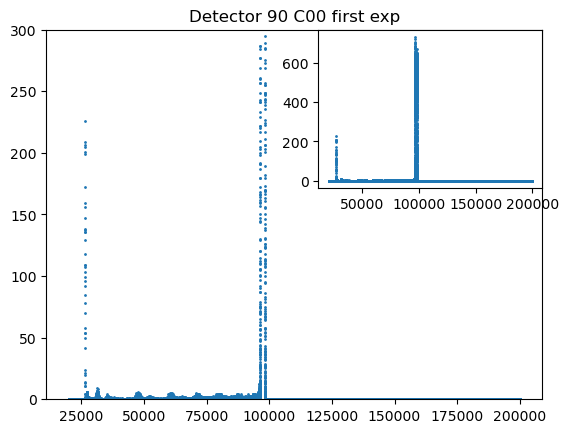

In [64]:
amp = "C00"
countsdict, bins = defineSensorAttributes(amp, 90, 0,1 ) 

counts = countsdict[amp]
print(sum(counts))

# Create the main figure and axes
fig, ax = plt.subplots()
ax.scatter(bins[:len(counts)], counts, s=1)
ax.set_title(f"Detector 90 {amp} first exp") 
ax.set_ylim(0, 300)

# Add an inset
inset_ax = fig.add_axes([0.55, 0.55, 0.35, 0.33])  # [left, bottom, width, height]
inset_ax.scatter(bins[:len(counts)], counts, s=1)

plt.show()

## Trim such 512X2002 pixels 

In [3]:
def getButler3(runnum, rtype, detectornum, amp):
    repo_path = "/repo/ir2"
    butler = Butler(repo_path, collections=['LSSTCam/photodiode','LSSTCam/raw/all'], instrument='LSSTCam')
    registry = butler.registry
    recordClasses = butler.registry.queryDimensionRecords('detector', where="instrument='LSSTCam'")
    det_raft_pairs = sorted([(rc.id, rc.full_name) for rc in recordClasses])    
    
    ## get Datarefs 
    where = f"exposure.science_program='{runnum}' and exposure.observation_type ='{rtype}'"
    collections = 'LSSTCam/raw/all'
    dataId = {'detector': detectornum}
    datarefs = list(butler.registry.queryDatasets(datasetType='raw', collections=collections, where=where, dataId=dataId))
    exp = butler.get(datarefs[0]) #use just the first image : ) 
    det = exp.getDetector()
    #amps_list = [amp]
    
    amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    ampNames = [amp.getName() for amp in det if amp.getName() in amps_list] #the order in which the channels are in the dataset 
   
    #bins = np.arange(2e4, 2e5)
    for dataref in datarefs[:1]:
        
        fig, axes = plt.subplots(2, 8,figsize=(20,12))
        exp = butler.get(dataref) 
        det = exp.getDetector()
        trimmed_ims = [exp.getMaskedImage()[amp.getRawDataBBox()].getImage() for amp in det if amp.getName() in amps_list]
        int_ims = [trimmed_im.getArray().astype(int) for trimmed_im in trimmed_ims]
        trimmeddict = {ampName: int_ims for ampName, int_ims in zip(ampNames, int_ims)}
        
        i = 0 
        j = 0 

        for amplifier in trimmeddict:
            ax = axes[j, i]
            
            plotable= trimmeddict[amplifier]             
            pltim = ax.imshow(plotable, vmin=90000, vmax=110000)
            #pltim = ax.imshow(plotable)


            ax.set_title(amplifier) # show each amp's name above its image
    
            divider = make_axes_locatable(ax)
            cax = divider.new_horizontal(size="10%", pad=0.2)
            fig.add_axes(cax)
            fig.colorbar(pltim, cax=cax, orientation="vertical")

            xax = ax.get_xaxis().set_visible(False)
    
            yax = ax.get_yaxis().set_visible(False)

            i +=1 
            
            if i > 7:
                j = 1
                i = 0 
    
        plt.suptitle(f'Run {runnum}');
        plt.tight_layout()
        plt.show()

    return trimmeddict

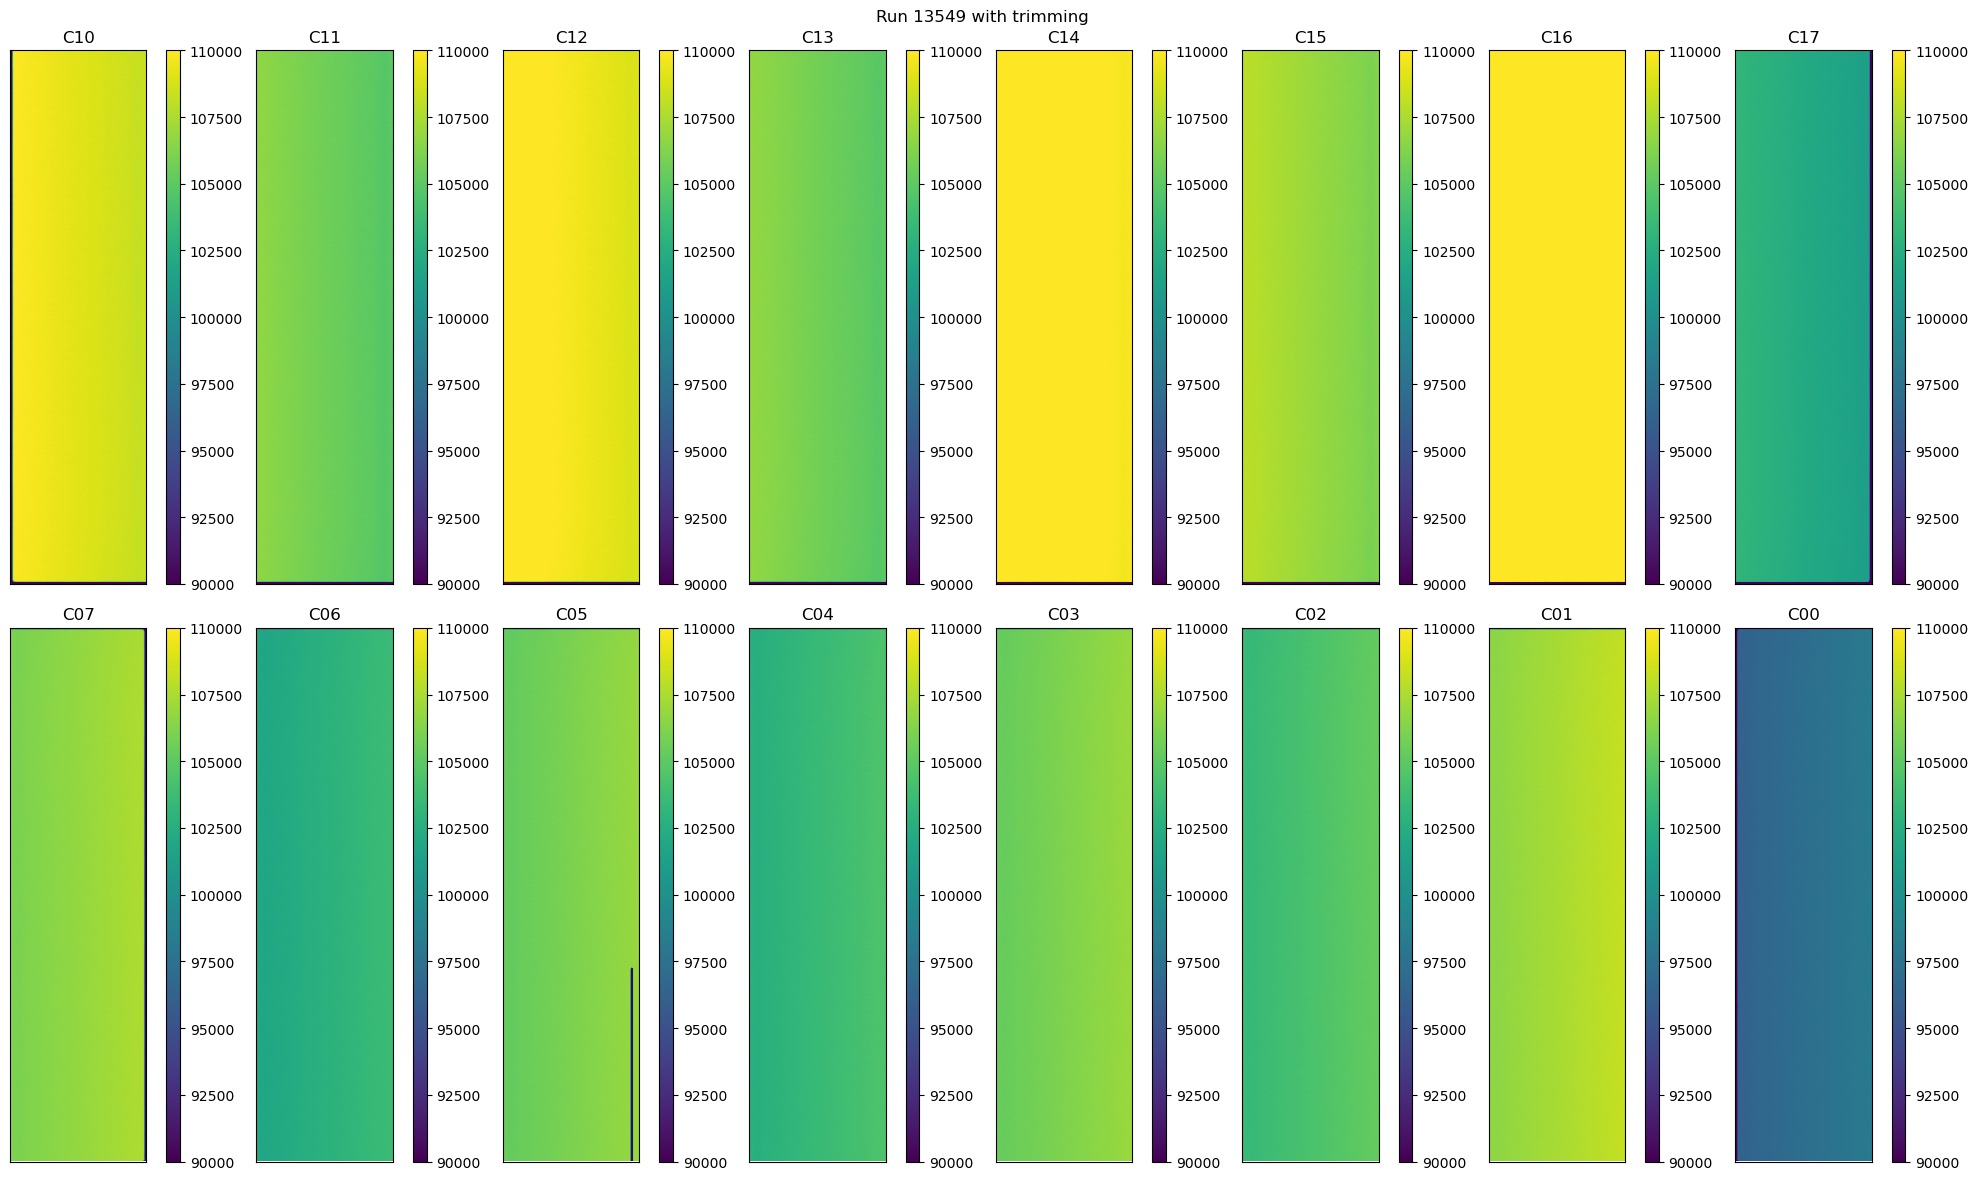

In [4]:
trimmeddict = getButler3(13549, "ramp", 90, "C01")

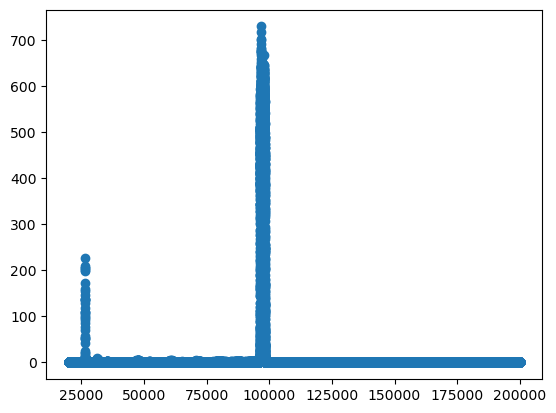

In [5]:
rawcounts  = trimmeddict["C00"]
counts, bins = np.histogram(rawcounts, bins=np.arange(2e4, 2e5))
plt.scatter(bins[:len(counts)], counts) 

## Try removing the picture frame 

In [4]:
def getButler4(runnum, rtype, detectornum, npix):
    repo_path = "/repo/ir2"
    butler = Butler(repo_path, collections=['LSSTCam/photodiode','LSSTCam/raw/all'], instrument='LSSTCam')
    registry = butler.registry
    recordClasses = butler.registry.queryDimensionRecords('detector', where="instrument='LSSTCam'")
    det_raft_pairs = sorted([(rc.id, rc.full_name) for rc in recordClasses])    
    
    ## get Datarefs 
    where = f"exposure.science_program='{runnum}' and exposure.observation_type ='{rtype}'"
    collections = 'LSSTCam/raw/all'
    dataId = {'detector': detectornum}
    datarefs = list(butler.registry.queryDatasets(datasetType='raw', collections=collections, where=where, dataId=dataId))
    exp = butler.get(datarefs[0]) #use just the first image : ) 
    det = exp.getDetector()
    #amps_list = [amp]
    
    amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    ampNames = [amp.getName() for amp in det if amp.getName() in amps_list] #the order in which the channels are in the dataset 
    
    trimsides = ["C00", "C10", "C07", "C17"]

    trimtops = ["C00", "C01", "C02","C03","C04","C05","C06", "C07"]
    trimbottoms = ["C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    
    bins = np.arange(2e4, 2e5)
    for dataref in datarefs[:1]:
        fig, axes = plt.subplots(2, 8,figsize=(20,12))
        exp = butler.get(dataref) 
        det = exp.getDetector()
        trimmed_ims = [exp.getMaskedImage()[amp.getRawDataBBox()].getImage() for amp in det if amp.getName() in amps_list]
        int_ims = [trimmed_im.getArray().astype(int) for trimmed_im in trimmed_ims]
        trimmeddict = {ampName: int_ims for ampName, int_ims in zip(ampNames, int_ims)}

        # trim again the corner amplifiers by ~ 8 pixels or so (?) 

        for amp in trimtops: 
            array = trimmeddict[amp] 
            
            if amp == 'C00': 
                #side = npix*2 
                side = npix
                trimmed_array = array[npix:, side:] # [top:bottom, left:right]
                trimmeddict[amp] = trimmed_array

            elif amp == 'C07':
                #side = npix*2 
                side = npix

                trimmed_array = array[npix:, :-side]
                trimmeddict[amp] = trimmed_array

            else: 
                trimmed_array = array[npix:, :]
                trimmeddict[amp] = trimmed_array


        for amp in trimbottoms: 
            array = trimmeddict[amp] 
            
            if amp == 'C10': 
                #side = npix*2 
                side = npix
                trimmed_array = array[:-npix, side:]  # [top:bottom, left:right]
                trimmeddict[amp] = trimmed_array

            elif amp == 'C17':
                #side = npix*2 
                side = npix
                trimmed_array = array[:-npix, :-side]
                #trimmed_array = array[npix:, side:]  ## [top:bottom, left:right]
                trimmeddict[amp] = trimmed_array

            else: 
                trimmed_array = array[:-npix, :]
                trimmeddict[amp] = trimmed_array

        i = 0 
        j = 0 
        for amplifier in trimmeddict:
            ax = axes[j, i]
            
            plotable= trimmeddict[amplifier]             
            #pltim = ax.imshow(plotable, vmin=90000, vmax=110000)
            pltim = ax.imshow(plotable)

            ax.set_title(amplifier) # show each amp's name above its image
    
            divider = make_axes_locatable(ax)
            cax = divider.new_horizontal(size="10%", pad=0.2)
            fig.add_axes(cax)
            fig.colorbar(pltim, cax=cax, orientation="vertical")

            xax = ax.get_xaxis().set_visible(False)
    
            yax = ax.get_yaxis().set_visible(False)

            i +=1
            
            if i > 7:
                j = 1
                i = 0 
    
        plt.suptitle(f'Run {runnum} with removing "picture frame" and {npix} pixels');
        plt.tight_layout()
        plt.show()

        ## now histogram these 
        countsdictionary = {} 
        for amp in trimmeddict: 
            array = trimmeddict[amp] 
            flattenarray = array.flatten() 
            counts, bins = np.histogram(flattenarray, bins= bins)
            countsdictionary[amp] = counts
    
    return countsdictionary 

In [5]:
countsdictionary = getButler4(13549, "ramp", 90, 8)

FileNotFoundError: Config location file:///repo/ir2 does not exist. (given '/repo/ir2' and no known aliases: Butler repository index file at /project/data-repos.yaml could not be read: OSError [Errno 116] Stale file handle: '/project/data-repos.yaml')

In [ ]:
countsdictionary = getButler4(13549, "ramp", 90, 2)

## 6. Remove PF then make super hist by # pixels removed

In [5]:
def getButler5(runnum, rtype, detectornum, npix):
    repo_path = "/repo/ir2"
    butler = Butler(repo_path, collections=['LSSTCam/photodiode','LSSTCam/raw/all'], instrument='LSSTCam')
    registry = butler.registry
    recordClasses = butler.registry.queryDimensionRecords('detector', where="instrument='LSSTCam'")
    det_raft_pairs = sorted([(rc.id, rc.full_name) for rc in recordClasses])    
    
    ## get Datarefs 
    where = f"exposure.science_program='{runnum}' and exposure.observation_type ='{rtype}'"
    collections = 'LSSTCam/raw/all'
    dataId = {'detector': detectornum}
    datarefs = list(butler.registry.queryDatasets(datasetType='raw', collections=collections, where=where, dataId=dataId))
    
    exp = butler.get(datarefs[0]) #use just the first image : ) 
    det = exp.getDetector()
    
    amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    ampNames = [amp.getName() for amp in det if amp.getName() in amps_list] #the order in which the channels are in the dataset 
    
    trimtops = ["C00", "C01", "C02","C03","C04","C05","C06", "C07"]
    trimbottoms = ["C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    
    bins = np.arange(2e4, 2e5)
    countsdictionary = {} 

    for dataref in datarefs:
        exp = butler.get(dataref) 
        det = exp.getDetector()
        trimmed_ims = [exp.getMaskedImage()[amp.getRawDataBBox()].getImage() for amp in det if amp.getName() in amps_list]
        int_ims = [trimmed_im.getArray().astype(int) for trimmed_im in trimmed_ims]
        trimmeddict = {ampName: int_ims for ampName, int_ims in zip(ampNames, int_ims)}

        for amp in trimtops:
            #npix = 8
            array = trimmeddict[amp] 
            
            if amp == 'C00': 
                #side = npix*2 
                side = npix
                trimmed_array = array[npix:, side:] # [top:bottom, left:right]
                trimmeddict[amp] = trimmed_array

            elif amp == 'C07':
                #side = npix*2 
                side = npix

                trimmed_array = array[npix:, :-side]
                trimmeddict[amp] = trimmed_array

            else: 
                trimmed_array = array[npix:, :]
                trimmeddict[amp] = trimmed_array


        for amp in trimbottoms: 
            #npix = 10
            array = trimmeddict[amp] 
            
            if amp == 'C10': 
                #side = npix*2 
                side = npix
                trimmed_array = array[:-npix, side:]  # [top:bottom, left:right]
                trimmeddict[amp] = trimmed_array

            elif amp == 'C17':
                #side = npix*2 
                side = npix
                trimmed_array = array[:-npix, :-side]
                #trimmed_array = array[npix:, side:]  ## [top:bottom, left:right]
                trimmeddict[amp] = trimmed_array

            else: 
                trimmed_array = array[:-npix, :]
                trimmeddict[amp] = trimmed_array

        ## now histogram these 
        
        for amp in trimmeddict: 
            array = trimmeddict[amp] 
            flattenarray = array.flatten() 
            counts, bins = np.histogram(flattenarray, bins= bins)

            if amp not in countsdictionary.keys(): 
                countsdictionary[amp] = counts  
            else: 
                countsdictionary[amp] = list(map(add, countsdictionary[amp], counts ))
    
    return countsdictionary 

In [8]:
## run the above for removing various numbers of pixels from the "picture frame" 
# DO NOT RUN 

for x in range(6): 
    dicttosave = getButler5(13549, "ramp", 90, x)

    filename = f'remove{x}pixelsfromedge90.pkl'
    directory = '/home/r/rejnicho/'
    fullfilename = os.path.join(directory, filename)
    with open(fullfilename, 'wb') as f:
        pkl.dump(dicttosave, f)

0 0


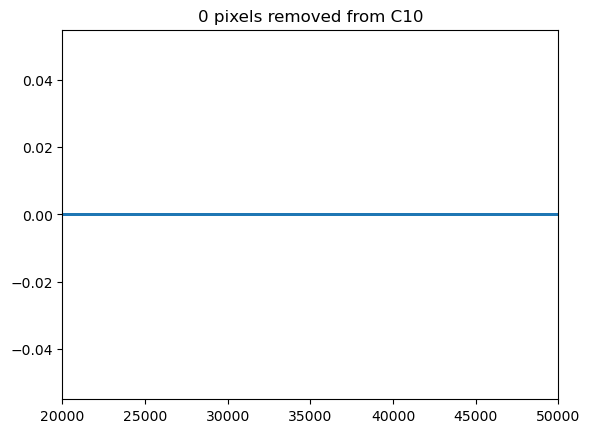

1 237625128


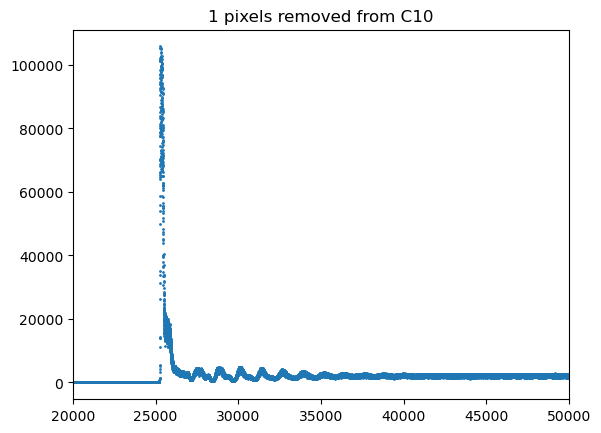

2 237038724


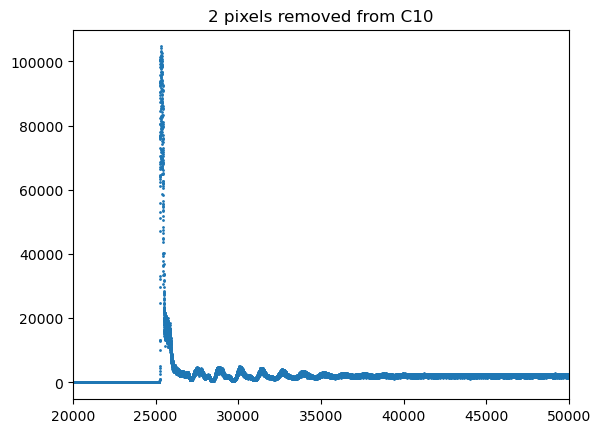

3 236452788


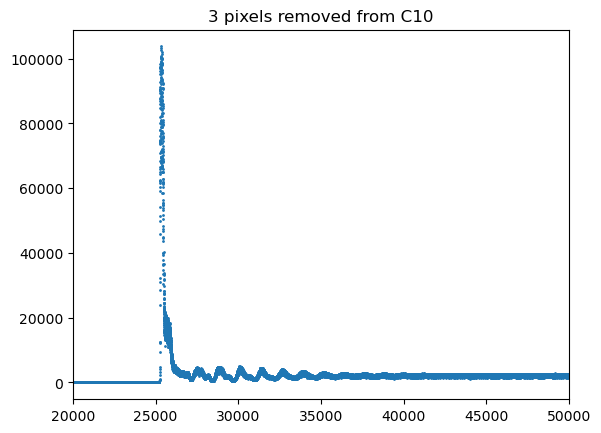

4 235867320


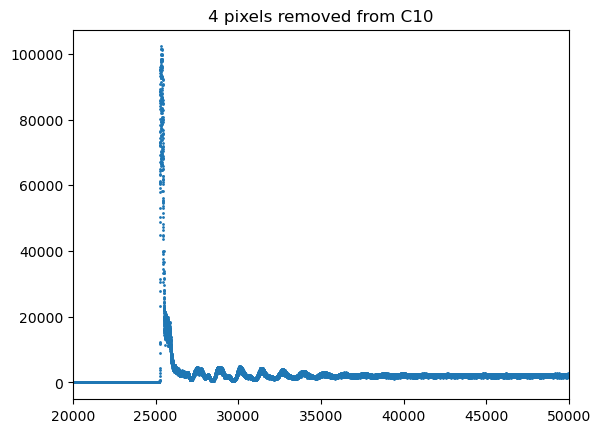

5 235282320


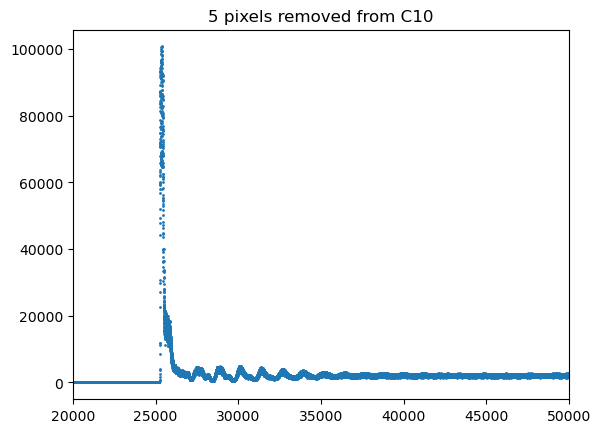

In [5]:
amplifier = "R41_S20_C10" 

for x in range(6):
    filename = f'{amplifier}remove{x}pixelsfromedge.pkl'
    directory = '/home/r/rejnicho/adc_investigation/adcbinning/focalplane/githubfiles/'
    fullfilename = os.path.join(directory, filename)
    with open(fullfilename, 'rb') as f:
        countsdictionary = pkl.load(f) 

    amp = 'C10'
    counts = countsdictionary[amp]
    print(x, sum(counts))
    bins = np.arange(2e4, 2e5)
    plt.scatter(bins[:len(counts)], counts, s=1)
    plt.title(f'{x} pixels removed from {amp}')
    plt.xlim(20000,50000)
    #plt.ylim(0, 10000)
    plt.show()

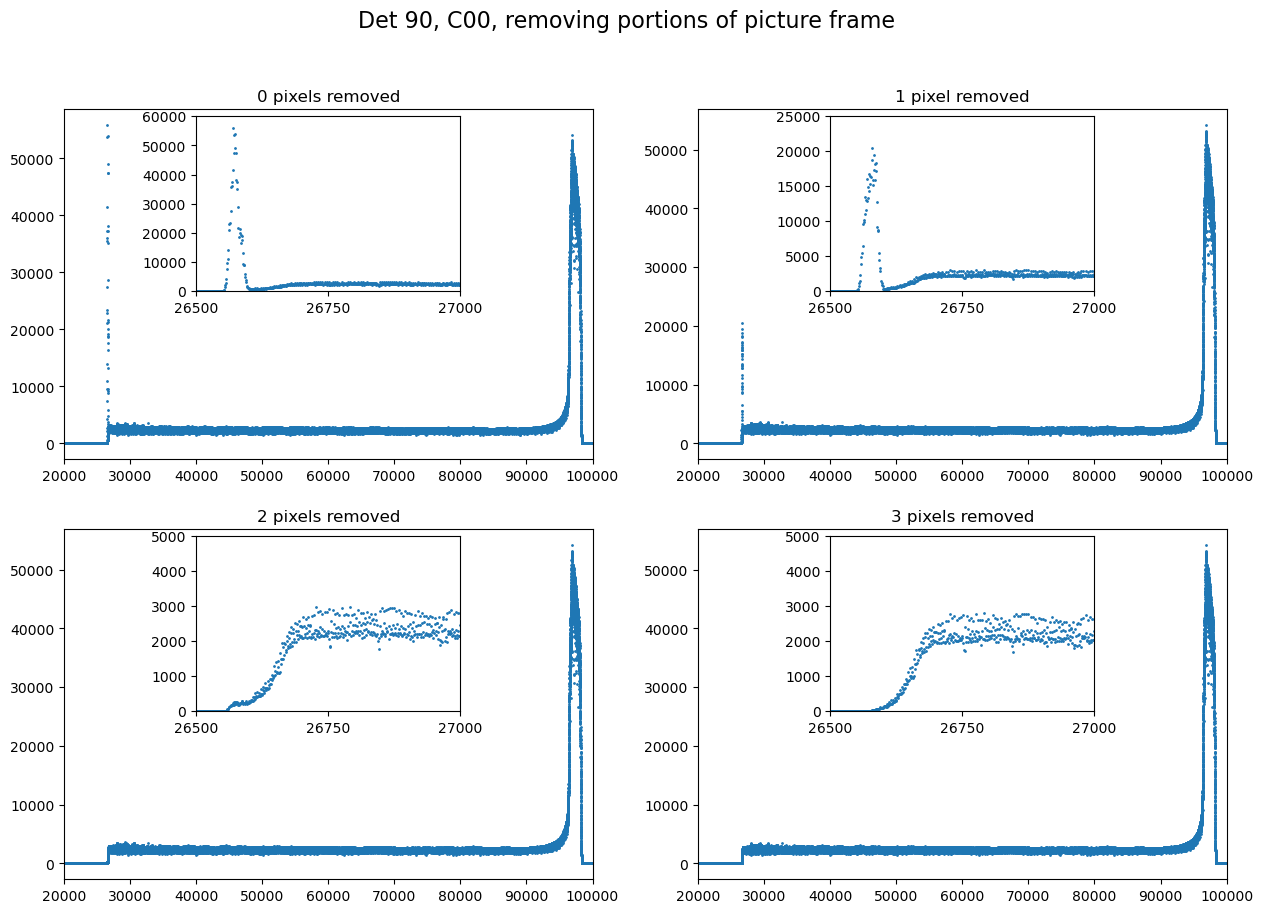

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

localdata = {}
for x in range(4):
    filename = f'remove{x}pixelsfromedge90.pkl'
    directory = '/home/r/rejnicho/'
    fullfilename = os.path.join(directory, filename)
    with open(fullfilename, 'rb') as f:
        countsdictionary = pkl.load(f) 

    amp = 'C00'
    counts = countsdictionary[amp]

    localdata[x] = counts
    #bins = np.arange(2e4, 2e5)
    #plt.scatter(bins[:len(counts)], counts, s=1)
    #plt.title(f'{x} pixels removed from det 90 {amp}')
    #plt.xlim(20000,100000)
    #plt.show()

amp = 'C00'
#counts = localdata[x]
bins = np.arange(2e4, 2e5)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
x_limits = (20000, 100000)

inset_xlim = (26500, 27000)

# First plot
axs[0, 0].scatter(bins[:len(localdata[0])], localdata[0], s=1)
axs[0, 0].set_title('0 pixels removed')
axs[0, 0].set_xlim(x_limits)

axins1 = inset_axes(axs[0, 0], width="50%", height="50%", loc='upper center')
axins1.scatter(bins[:len(localdata[0])], localdata[0], s=1)
axins1.set_xlim(inset_xlim)
axins1.set_ylim(0, 6e4)
axins1.set_xticks([26500, 26750, 27000])

# Second plot
axs[0, 1].scatter(bins[:len(localdata[1])], localdata[1], s=1)
axs[0, 1].set_title('1 pixel removed')
axs[0, 1].set_xlim(x_limits)

axins2 = inset_axes(axs[0, 1], width="50%", height="50%", loc='upper center')
axins2.scatter(bins[:len(localdata[1])], localdata[1], s=1)
axins2.set_ylim(0, 25000)
axins2.set_xlim(inset_xlim)
axins2.set_xticks([26500, 26750, 27000])

# Third plot
axs[1, 0].scatter(bins[:len(localdata[2])], localdata[2], s=1)
axs[1, 0].set_title('2 pixels removed')
axs[1, 0].set_xlim(x_limits)

axins3 = inset_axes(axs[1, 0], width="50%", height="50%", loc='upper center')
axins3.scatter(bins[:len(localdata[2])], localdata[2], s=1)
axins3.set_xlim(inset_xlim)
axins3.set_ylim(0, 5000)
axins3.set_xticks([26500, 26750, 27000])

# Fourth plot
axs[1, 1].scatter(bins[:len(localdata[3])], localdata[3], s=1)
axs[1, 1].set_title('3 pixels removed')
axs[1, 1].set_xlim(x_limits)

axins4 = inset_axes(axs[1, 1], width="50%", height="50%", loc='upper center')
axins4.scatter(bins[:len(localdata[3])], localdata[3], s=1)
axins4.set_xlim(inset_xlim)
axins4.set_ylim(0, 5000)
axins4.set_xticks([26500, 26750, 27000])

plt.suptitle(f'Det 90, {amp}, removing portions of picture frame', fontsize=16)
plt.show()


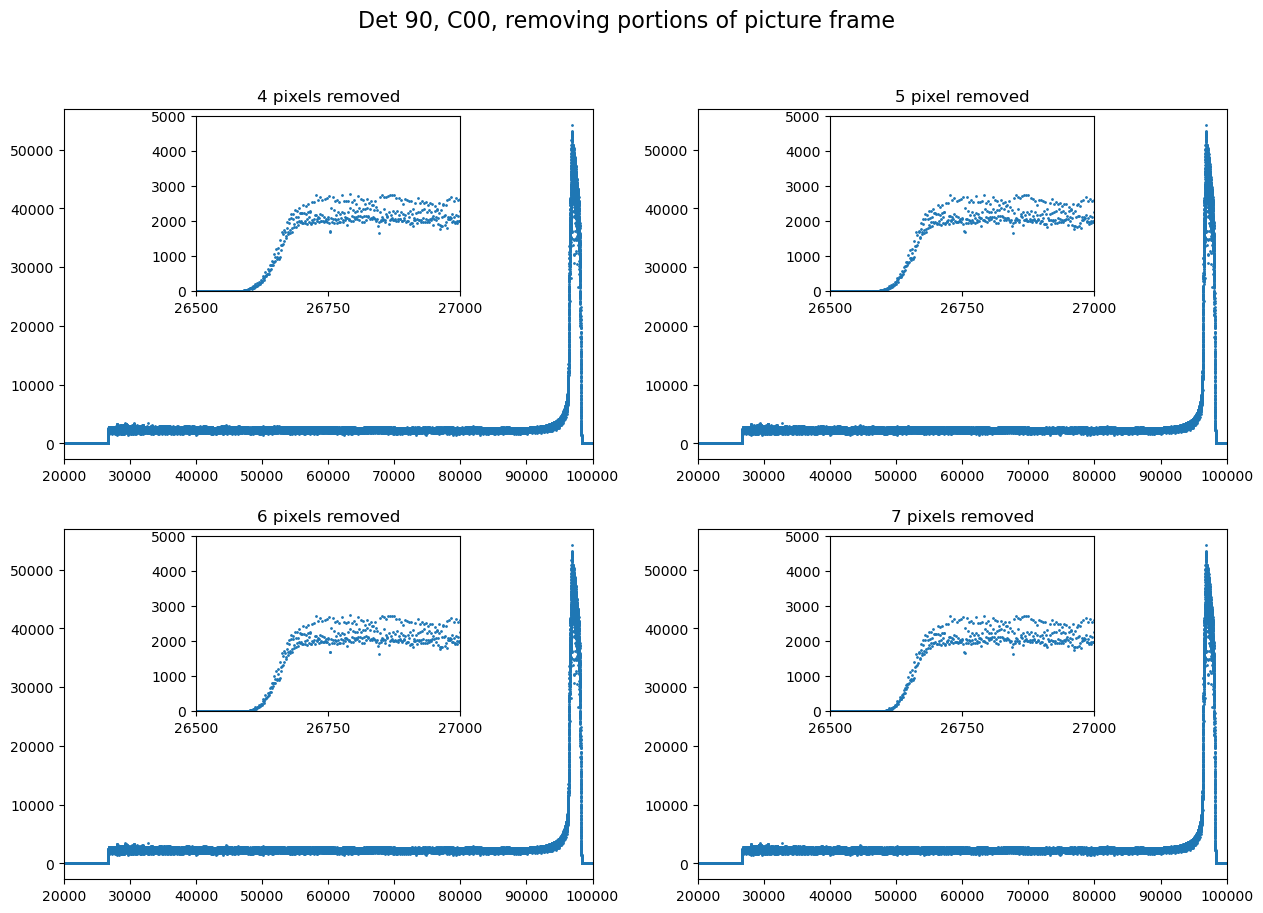

In [10]:
amp = 'C00'
localdata = {}
for x in range(4):
    val = 4 + x
    filename = f'remove{val}pixelsfromedge90.pkl'
    directory = '/home/r/rejnicho/'
    fullfilename = os.path.join(directory, filename)
    with open(fullfilename, 'rb') as f:
        countsdictionary = pkl.load(f) 

    counts = countsdictionary[amp]
    localdata[x] = counts
    
#counts = localdata[x]
bins = np.arange(2e4, 2e5)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
x_limits = (20000, 100000)

inset_xlim = (26500, 27000)

# First plot
axs[0, 0].scatter(bins[:len(localdata[0])], localdata[0], s=1)
axs[0, 0].set_title('4 pixels removed')
axs[0, 0].set_xlim(x_limits)

axins1 = inset_axes(axs[0, 0], width="50%", height="50%", loc='upper center')
axins1.scatter(bins[:len(localdata[0])], localdata[0], s=1)
axins1.set_xlim(inset_xlim)
axins1.set_ylim(0, 5000)
axins1.set_xticks([26500, 26750, 27000])

# Second plot
axs[0, 1].scatter(bins[:len(localdata[1])], localdata[1], s=1)
axs[0, 1].set_title('5 pixel removed')
axs[0, 1].set_xlim(x_limits)

axins2 = inset_axes(axs[0, 1], width="50%", height="50%", loc='upper center')
axins2.scatter(bins[:len(localdata[1])], localdata[1], s=1)
axins2.set_ylim(0, 5000)
axins2.set_xlim(inset_xlim)
axins2.set_xticks([26500, 26750, 27000])

# Third plot
axs[1, 0].scatter(bins[:len(localdata[2])], localdata[2], s=1)
axs[1, 0].set_title('6 pixels removed')
axs[1, 0].set_xlim(x_limits)

axins3 = inset_axes(axs[1, 0], width="50%", height="50%", loc='upper center')
axins3.scatter(bins[:len(localdata[2])], localdata[2], s=1)
axins3.set_xlim(inset_xlim)
axins3.set_ylim(0, 5000)
axins3.set_xticks([26500, 26750, 27000])

# Fourth plot
axs[1, 1].scatter(bins[:len(localdata[3])], localdata[3], s=1)
axs[1, 1].set_title('7 pixels removed')
axs[1, 1].set_xlim(x_limits)

axins4 = inset_axes(axs[1, 1], width="50%", height="50%", loc='upper center')
axins4.scatter(bins[:len(localdata[3])], localdata[3], s=1)
axins4.set_xlim(inset_xlim)
axins4.set_ylim(0, 5000)
axins4.set_xticks([26500, 26750, 27000])

plt.suptitle(f'Det 90, {amp}, removing portions of picture frame', fontsize=16)
plt.show()

## Understand the high peak

(94000.0, 100000.0)

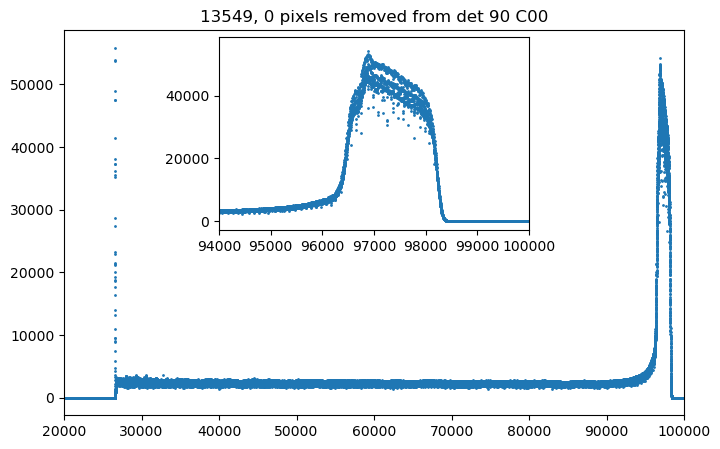

In [28]:
## reference

filename = f'remove0pixelsfromedge90.pkl'
directory = '/home/r/rejnicho/'
fullfilename = os.path.join(directory, filename)
with open(fullfilename, 'rb') as f:
    countsdictionary = pkl.load(f) 

amp = 'C00'
counts = countsdictionary[amp]
bins = np.arange(2e4, 2e5)

fig, axs = plt.subplots(1, 1, figsize=(8, 5))

axs.scatter(bins[:len(counts)], counts, s=1)
axs.set_title(f'13549, 0 pixels removed from det 90 {amp}')
axs.set_xlim(20000, 100000)

axins1 = inset_axes(axs, width="50%", height="50%", loc='upper center')
axins1.scatter(bins[:len(counts)], counts, s=1)
axins1.set_xlim(94000, 100000)

In [5]:
def getButler10(runnum, rtype, detectornum, npix, imageno):
    repo_path = "/repo/ir2"
    butler = Butler(repo_path, collections=['LSSTCam/photodiode','LSSTCam/raw/all'], instrument='LSSTCam')
    registry = butler.registry
    recordClasses = butler.registry.queryDimensionRecords('detector', where="instrument='LSSTCam'")
    det_raft_pairs = sorted([(rc.id, rc.full_name) for rc in recordClasses])    
    
    ## get Datarefs 
    where = f"exposure.science_program='{runnum}' and exposure.observation_type ='{rtype}'"
    collections = 'LSSTCam/raw/all'
    dataId = {'detector': detectornum}
    datarefs = list(butler.registry.queryDatasets(datasetType='raw', collections=collections, where=where, dataId=dataId))
    
    exp = butler.get(datarefs[0]) #use just the first image : ) 
    det = exp.getDetector()
    amps_list=["C00"]
    #amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    ampNames = [amp.getName() for amp in det if amp.getName() in amps_list] #the order in which the channels are in the dataset 
    
    trimtops = ["C00", "C01", "C02","C03","C04","C05","C06", "C07"]
    trimbottoms = ["C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    
    bins = np.arange(2e4, 2e5)
    countsdictionary = {} 

    for dataref in datarefs[imageno:imageno+1]:
        exp = butler.get(dataref) 
        det = exp.getDetector()
        trimmed_ims = [exp.getMaskedImage()[amp.getRawDataBBox()].getImage() for amp in det if amp.getName() in amps_list]
        int_ims = [trimmed_im.getArray().astype(int) for trimmed_im in trimmed_ims]
        trimmeddict = {ampName: int_ims for ampName, int_ims in zip(ampNames, int_ims)}
        ## skip a bunch 

        
        for amp in trimmeddict: 
            array = trimmeddict[amp] 
            flattenarray = array.flatten() 
            counts, bins = np.histogram(flattenarray, bins= bins)
        
        if amp not in countsdictionary.keys(): 
            countsdictionary[amp] = counts  
        else: 
            countsdictionary[amp] = list(map(add, countsdictionary[amp], counts ))
    
    return countsdictionary 

In [8]:
from scipy.signal import find_peaks

highpeakdatarefs = [] 

for x in range(234):
    countsdictionary = getButler10(13549, "ramp", 90, 0, x)
    counts = countsdictionary["C00"]
    bins = np.arange(2e4, 2e5)
    
    peaks, _ = find_peaks(counts, height=500)

    exists = any(value > 76000 for value in peaks)

    #print(x, exists)

    if exists: 
        highpeakdatarefs.append(x) 
    #plt.scatter(bins[:len(counts)], counts, s=1)
    #plt.xlim(20000, 125000)
    #plt.title(f"run 13549 det 90, C00 single exposure, image no {x}") 
    #plt.show()

In [9]:
print(highpeakdatarefs)

[0, 2, 6, 7, 14, 18, 19, 20, 21, 22, 25, 26, 29, 30, 34, 36, 39, 42, 48, 51, 55, 56, 61, 65, 69, 75, 76, 81, 83, 87, 92, 95, 98, 101, 105, 110, 117, 123, 124, 127, 128, 142, 144, 145, 148, 149, 153, 154, 155, 159, 160, 163, 164, 167, 177, 178, 180, 182, 183, 186, 187, 192, 195, 197, 201, 202, 204, 211, 212, 216, 217, 220, 225, 226, 228, 229, 231, 233]


(94000.0, 100000.0)

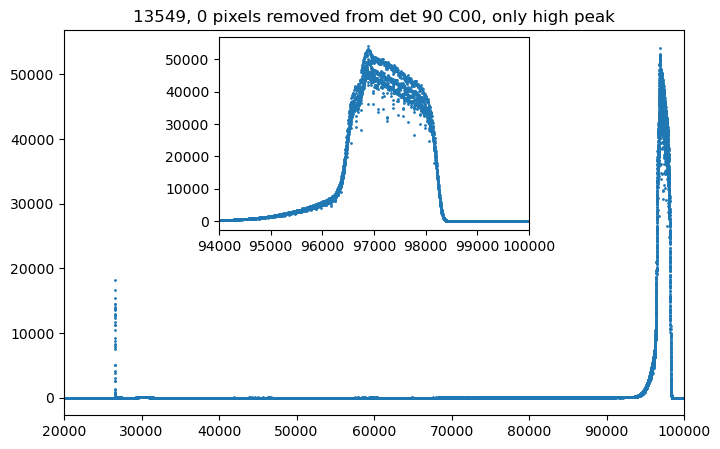

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# vals = highpeakdatarefs 
#vals = [0, 2, 6, 7, 14, 18, 19, 20, 21, 22, 25, 26, 29, 30, 34, 36, 39, 42, 48, 51, 55, 
#        56, 61, 65, 69, 75, 76, 81, 83, 87, 92, 95, 98, 101, 105, 110, 117, 123, 124, 127, 
#        128, 142, 144, 145, 148, 149, 153, 154, 155, 159, 160, 163, 164, 167, 177, 178, 180, 
#        182, 183, 186, 187, 192, 195, 197, 201, 202, 204, 211, 213, 217, 218, 225, 229, 230, 231, 232, 233]

vals = [0, 2, 6, 7, 14, 18, 19, 20, 21, 22, 25, 26, 29, 30, 34, 36, 39, 42, 48, 51, 55, 
         56, 61, 65, 69, 75, 76, 81, 83, 87, 92, 95, 98, 101, 105, 110, 117, 123, 124, 127, 
        128, 142, 144, 145, 148, 149, 153, 154, 155, 159, 160, 163, 164, 167, 177, 178, 180, 
        182, 183, 186, 187, 192, 195, 197, 201, 202, 204, 211, 212, 216, 217, 220, 225, 226, 228, 229, 231, 233]


fullhighpeakhist = [] 
x = 0
for val in vals: 
    countsdictionary = getButler10(13549, "ramp", 90, 0, val)

    if x == 0: 
        fullhighpeakhist = countsdictionary["C00"]

    else: 
        fullhighpeakhist = fullhighpeakhist + countsdictionary["C00"]

    x +=1 

fig, axs = plt.subplots(1, 1, figsize=(8, 5))

axs.scatter(bins[:len(fullhighpeakhist)], fullhighpeakhist, s=1)
axs.set_title(f'13549, 0 pixels removed from det 90 C00, only high peak')
axs.set_xlim(20000, 100000)

axins1 = inset_axes(axs, width="50%", height="50%", loc='upper center')
axins1.scatter(bins[:len(fullhighpeakhist)], fullhighpeakhist, s=1)
axins1.set_xlim(94000, 100000)

(94000.0, 100000.0)

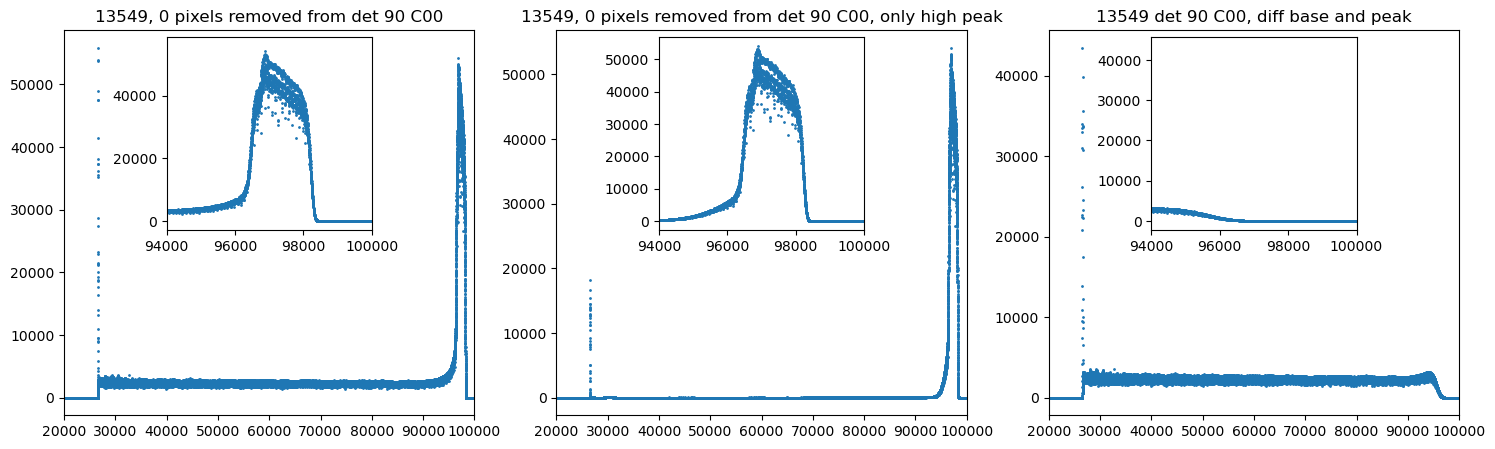

In [14]:
## compare the two, and subtract to see if it elininates 

## reference
filename = f'remove0pixelsfromedge90.pkl'
directory = '/home/r/rejnicho/'
fullfilename = os.path.join(directory, filename)
with open(fullfilename, 'rb') as f:
    countsdictionary = pkl.load(f) 

amp = 'C00'
counts = countsdictionary[amp]
bins = np.arange(2e4, 2e5)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# the base histogram 
axs[0].scatter(bins[:len(counts)], counts, s=1)
axs[0].set_title(f'13549, 0 pixels removed from det 90 {amp}')
axs[0].set_xlim(20000, 100000)

axins1 = inset_axes(axs[0], width="50%", height="50%", loc='upper center')
axins1.scatter(bins[:len(counts)], counts, s=1)
axins1.set_xlim(94000, 100000)


# just the high peaks 
axs[1].scatter(bins[:len(fullhighpeakhist)], fullhighpeakhist, s=1)
axs[1].set_title(f'13549, 0 pixels removed from det 90 C00, only high peak')
axs[1].set_xlim(20000, 100000)

axins2 = inset_axes(axs[1], width="50%", height="50%", loc='upper center')
axins2.scatter(bins[:len(fullhighpeakhist)], fullhighpeakhist, s=1)
axins2.set_xlim(94000, 100000)

# their difference
diff = counts - fullhighpeakhist 

axs[2].scatter(bins[:len(diff)], diff, s=1)
axs[2].set_title(f'13549 det 90 C00, diff base and peak')
axs[2].set_xlim(20000, 100000)

axins3 = inset_axes(axs[2], width="50%", height="50%", loc='upper center')
axins3.scatter(bins[:len(diff)], diff, s=1)
axins3.set_xlim(94000, 100000)

In [38]:
allvals = np.arange(0, 234)

valsEndPeak = [0, 2, 6, 7, 14, 18, 19, 20, 21, 22, 25, 26, 29, 30, 34, 36, 39, 42, 48, 51, 55, 
         56, 61, 65, 69, 75, 76, 81, 83, 87, 92, 95, 98, 101, 105, 110, 117, 123, 124, 127, 
        128, 142, 144, 145, 148, 149, 153, 154, 155, 159, 160, 163, 164, 167, 177, 178, 180, 
        182, 183, 186, 187, 192, 195, 197, 201, 202, 204, 211, 212, 216, 217, 220, 225, 226, 228, 229, 231, 233]

keepDatarefs = [item for item in allvals if item not in valsEndPeak]
print(keepDatarefs) 

[1, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 16, 17, 23, 24, 27, 28, 31, 32, 33, 35, 37, 38, 40, 41, 43, 44, 45, 46, 47, 49, 50, 52, 53, 54, 57, 58, 59, 60, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 77, 78, 79, 80, 82, 84, 85, 86, 88, 89, 90, 91, 93, 94, 96, 97, 99, 100, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 146, 147, 150, 151, 152, 156, 157, 158, 161, 162, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 179, 181, 184, 185, 188, 189, 190, 191, 193, 194, 196, 198, 199, 200, 203, 205, 206, 207, 208, 209, 210, 213, 214, 215, 218, 219, 221, 222, 223, 224, 227, 230, 232]


In [16]:
def getButler11(runnum, rtype, detectornum, npix):
    repo_path = "/repo/ir2"
    butler = Butler(repo_path, collections=['LSSTCam/photodiode','LSSTCam/raw/all'], instrument='LSSTCam')
    registry = butler.registry
    recordClasses = butler.registry.queryDimensionRecords('detector', where="instrument='LSSTCam'")
    det_raft_pairs = sorted([(rc.id, rc.full_name) for rc in recordClasses])    
    
    ## get Datarefs 
    where = f"exposure.science_program='{runnum}' and exposure.observation_type ='{rtype}'"
    collections = 'LSSTCam/raw/all'
    dataId = {'detector': detectornum}
    datarefs = list(butler.registry.queryDatasets(datasetType='raw', collections=collections, where=where, dataId=dataId))
    
    exp = butler.get(datarefs[0]) #use just the first image : ) 
    det = exp.getDetector()
    #amps_list=["C00"]
    
    amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    ampNames = [amp.getName() for amp in det if amp.getName() in amps_list] #the order in which the channels are in the dataset 
    
    trimtops = ["C00", "C01", "C02","C03","C04","C05","C06", "C07"]
    trimbottoms = ["C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    
    bins = np.arange(2e4, 2e5)
    countsdictionary = {} 
    
    keepDatarefs = [1, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 16, 17, 23, 24, 27, 28, 31, 32, 33, 35, 37, 38, 40, 41, 43, 44, 45, 46, 47, 49, 50, 
                    52, 53, 54, 57, 58, 59, 60, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 77, 78, 79, 80, 82, 84, 85, 86, 88, 89, 90, 91, 93, 
                    94, 96, 97, 99, 100, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 125, 126, 129, 
                    130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 146, 147, 150, 151, 152, 156, 157, 158, 161, 162, 165, 166, 168, 
                    169, 170, 171, 172, 173, 174, 175, 176, 179, 181, 184, 185, 188, 189, 190, 191, 193, 194, 196, 198, 199, 200, 203, 205, 206, 207, 208, 209, 
                    210, 213, 214, 215, 218, 219, 221, 222, 223, 224, 227, 230, 232]
    
    for x in keepDatarefs:
        exp = butler.get(datarefs[x]) 
        det = exp.getDetector()
        trimmed_ims = [exp.getMaskedImage()[amp.getRawDataBBox()].getImage() for amp in det if amp.getName() in amps_list]
        int_ims = [trimmed_im.getArray().astype(int) for trimmed_im in trimmed_ims]
        trimmeddict = {ampName: int_ims for ampName, int_ims in zip(ampNames, int_ims)}
        ## skip a bunch 
        
        for amp in trimmeddict: 
            array = trimmeddict[amp] 
            flattenarray = array.flatten() 
            counts, bins = np.histogram(flattenarray, bins= bins)
        
            if amp not in countsdictionary.keys(): 
                countsdictionary[amp] = counts  
            else: 
                countsdictionary[amp] = list(map(add, countsdictionary[amp], counts ))
    
    return countsdictionary 

In [17]:
countsdictionary = getButler11(13549, "ramp", 90, 0)

In [18]:
print(countsdictionary.keys())

dict_keys(['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C07', 'C06', 'C05', 'C04', 'C03', 'C02', 'C01', 'C00'])


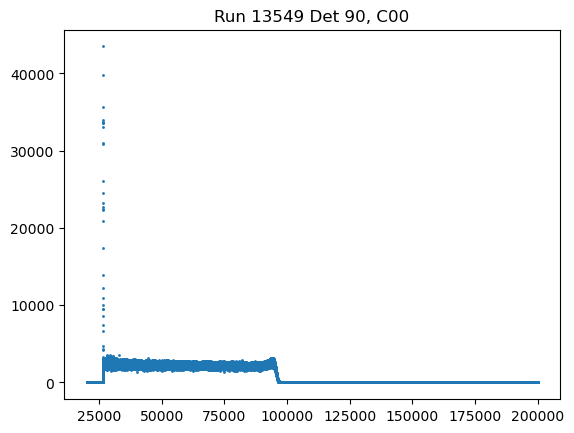

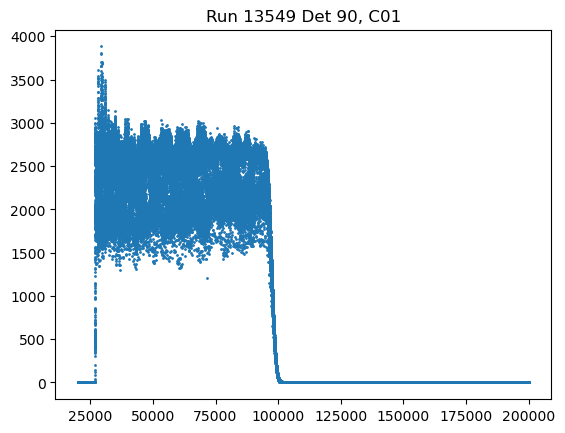

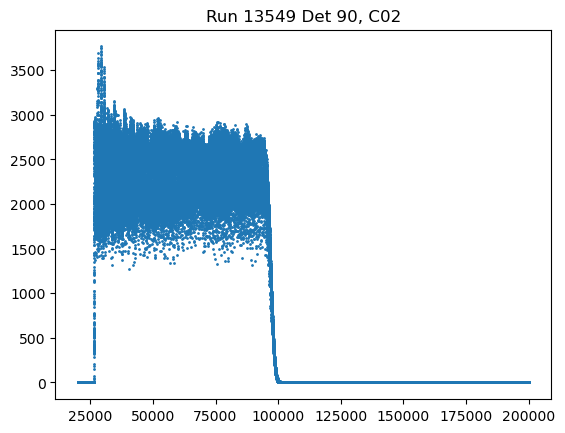

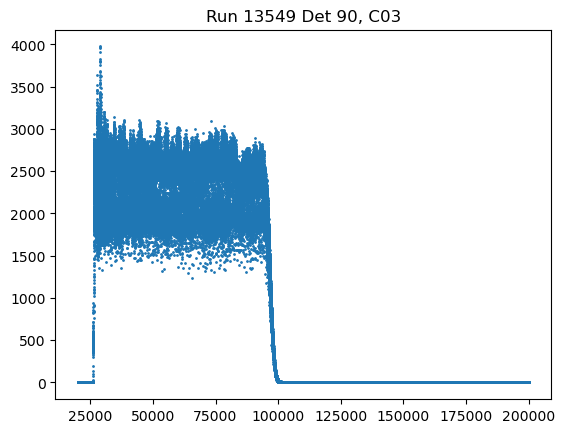

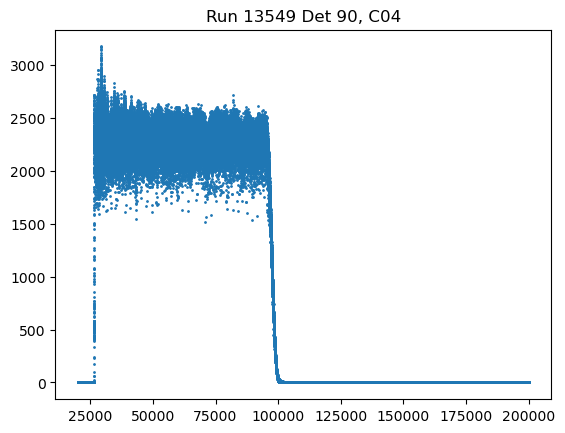

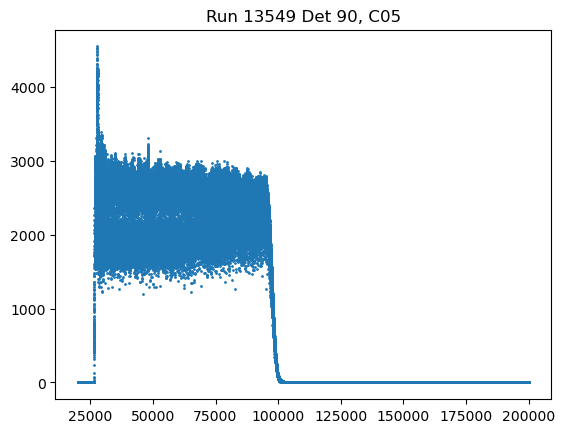

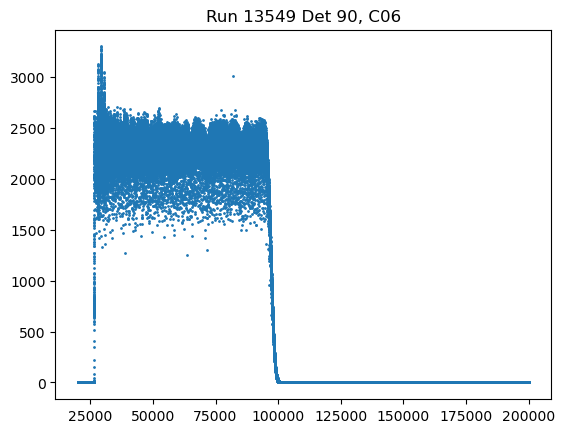

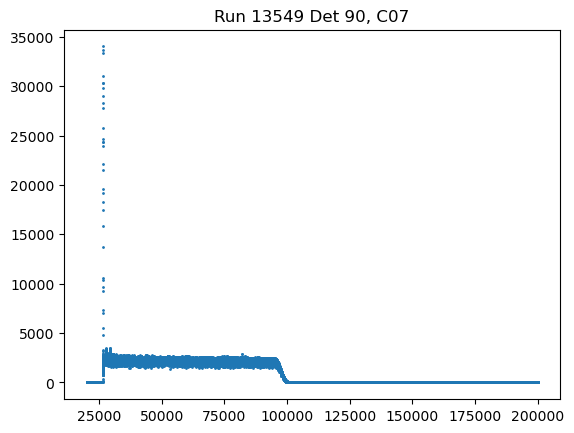

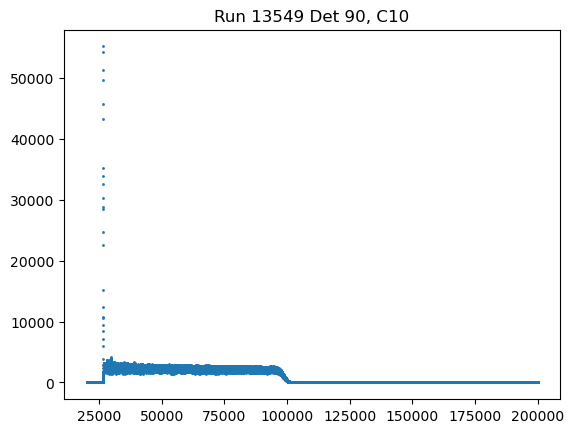

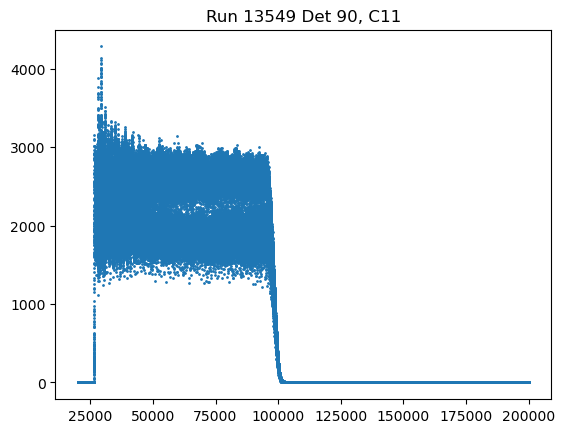

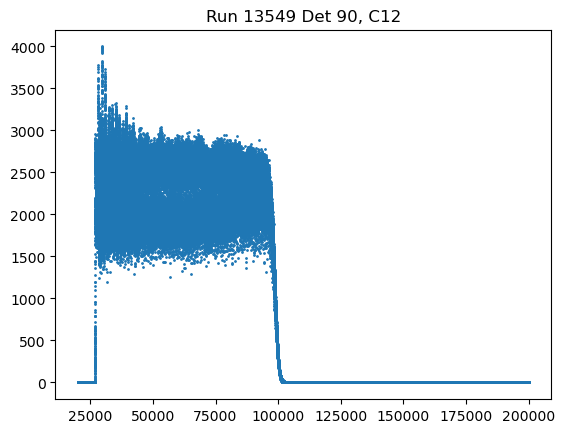

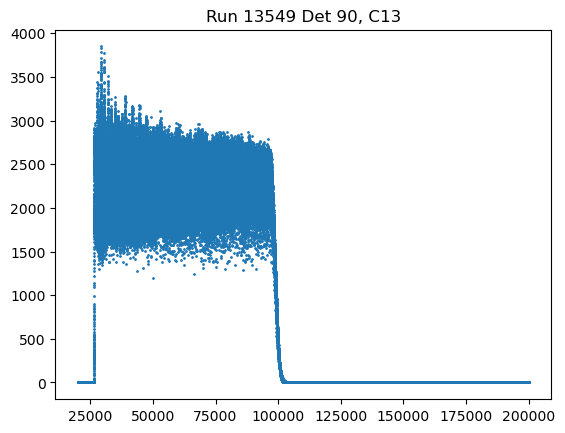

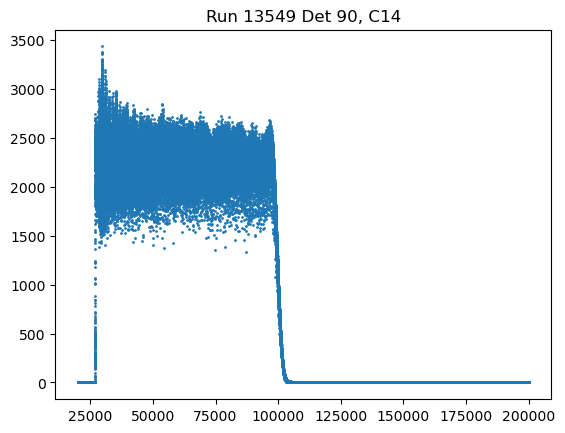

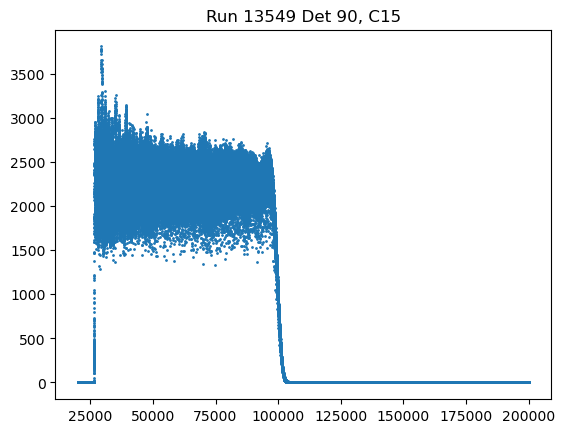

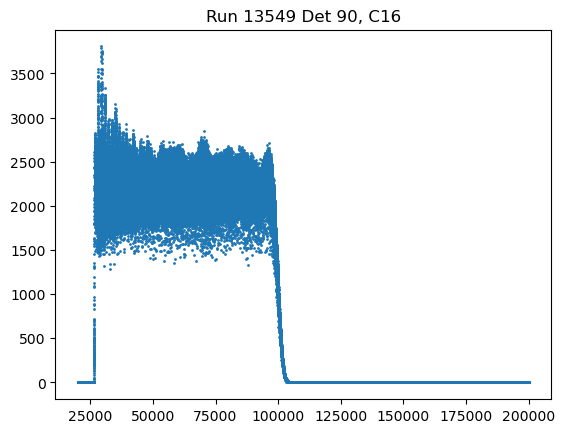

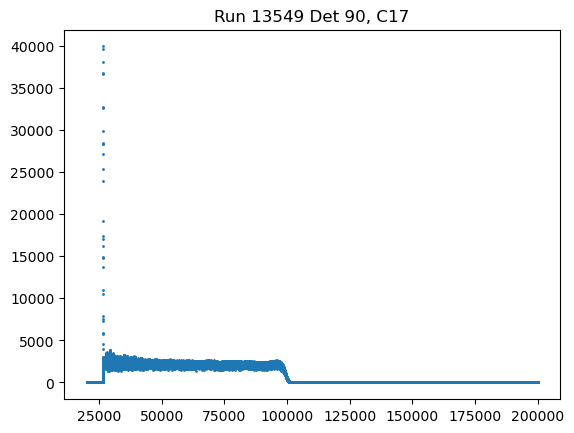

In [20]:
amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]

for amp in amps_list:
    counts = countsdictionary[amp]
    bins = np.arange(2e4, 2e5)
    plt.scatter(bins[:len(counts)], counts, s=1)
    plt.title(f"Run 13549 Det 90, {amp}")
    plt.show()

## Use only the non-peaking end exposures and the trimming from above 

In [3]:
## this removes exposures AND trims the E field 

def refineRampRun(runnum, rtype, detectornum, npix):
    repo_path = "/repo/ir2"
    butler = Butler(repo_path, collections=['LSSTCam/photodiode','LSSTCam/raw/all'], instrument='LSSTCam')
    registry = butler.registry
    recordClasses = butler.registry.queryDimensionRecords('detector', where="instrument='LSSTCam'")
    det_raft_pairs = sorted([(rc.id, rc.full_name) for rc in recordClasses])    
    
    ## get Datarefs 
    where = f"exposure.science_program='{runnum}' and exposure.observation_type ='{rtype}'"
    collections = 'LSSTCam/raw/all'
    dataId = {'detector': detectornum}
    datarefs = list(butler.registry.queryDatasets(datasetType='raw', collections=collections, where=where, dataId=dataId))
    
    exp = butler.get(datarefs[0]) #use just the first image : ) 
    det = exp.getDetector()
    
    amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    ampNames = [amp.getName() for amp in det if amp.getName() in amps_list] #the order in which the channels are in the dataset 
    
    trimtops = ["C00", "C01", "C02","C03","C04","C05","C06", "C07"]
    trimbottoms = ["C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    
    bins = np.arange(2e4, 2e5)
    countsdictionary = {} 
    
    keepDatarefs = [1, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 16, 17, 23, 24, 27, 28, 31, 32, 33, 35, 37, 38, 40, 41, 43, 44, 45, 46, 47, 49, 50, 
                    52, 53, 54, 57, 58, 59, 60, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 77, 78, 79, 80, 82, 84, 85, 86, 88, 89, 90, 91, 93, 
                    94, 96, 97, 99, 100, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 125, 126, 129, 
                    130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 146, 147, 150, 151, 152, 156, 157, 158, 161, 162, 165, 166, 168, 
                    169, 170, 171, 172, 173, 174, 175, 176, 179, 181, 184, 185, 188, 189, 190, 191, 193, 194, 196, 198, 199, 200, 203, 205, 206, 207, 208, 209, 
                    210, 213, 214, 215, 218, 219, 221, 222, 223, 224, 227, 230, 232]
    
    for x in keepDatarefs:
        exp = butler.get(datarefs[x]) 
        det = exp.getDetector()
        trimmed_ims = [exp.getMaskedImage()[amp.getRawDataBBox()].getImage() for amp in det if amp.getName() in amps_list]
        int_ims = [trimmed_im.getArray().astype(int) for trimmed_im in trimmed_ims]
        trimmeddict = {ampName: int_ims for ampName, int_ims in zip(ampNames, int_ims)}
        
        ## Trim the werid E field 
        for amp in trimtops:
            #npix = 8
            array = trimmeddict[amp] 
            
            if amp == 'C00': 
                #side = npix*2 
                side = npix
                trimmed_array = array[npix:, side:] # [top:bottom, left:right]
                trimmeddict[amp] = trimmed_array

            elif amp == 'C07':
                #side = npix*2 
                side = npix

                trimmed_array = array[npix:, :-side]
                trimmeddict[amp] = trimmed_array

            else: 
                trimmed_array = array[npix:, :]
                trimmeddict[amp] = trimmed_array


        for amp in trimbottoms: 
            #npix = 10
            array = trimmeddict[amp] 
            
            if amp == 'C10': 
                #side = npix*2 
                side = npix
                trimmed_array = array[:-npix, side:]  # [top:bottom, left:right]
                trimmeddict[amp] = trimmed_array

            elif amp == 'C17':
                #side = npix*2 
                side = npix
                trimmed_array = array[:-npix, :-side]
                #trimmed_array = array[npix:, side:]  ## [top:bottom, left:right]
                trimmeddict[amp] = trimmed_array

            else: 
                trimmed_array = array[:-npix, :]
                trimmeddict[amp] = trimmed_array

        ## now histogram these 
        ########        
        for amp in trimmeddict: 
            array = trimmeddict[amp] 
            flattenarray = array.flatten() 
            counts, bins = np.histogram(flattenarray, bins= bins)
        
            if amp not in countsdictionary.keys(): 
                countsdictionary[amp] = counts  
            else: 
                countsdictionary[amp] = list(map(add, countsdictionary[amp], counts ))
    
    return countsdictionary 

In [ ]:
# removes exposures and trims 

npixs = [0, 2, 8]
amp = 'C00' 

for npix in npixs: 
    fulldict = refineRampRun(13549, "ramp", 90, npix)
    
    filename = f'{npix}pixelsr90.pkl'
    directory = '/home/r/rejnicho/'
    fullfilename = os.path.join(directory, filename)
    with open(fullfilename, 'wb') as f:
        pkl.dump(fulldict, f)

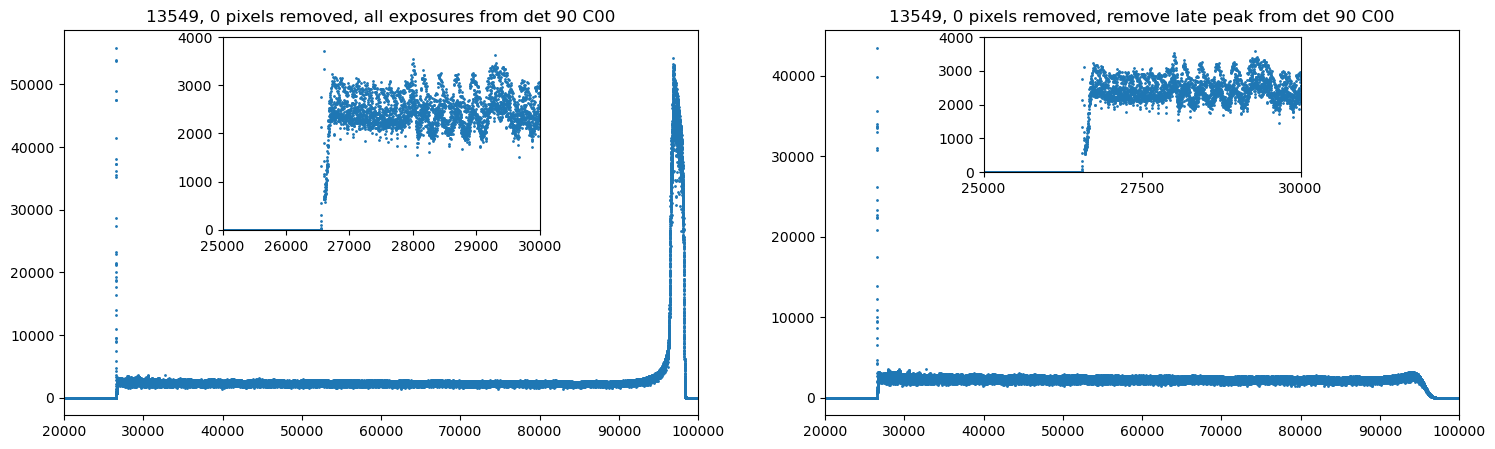

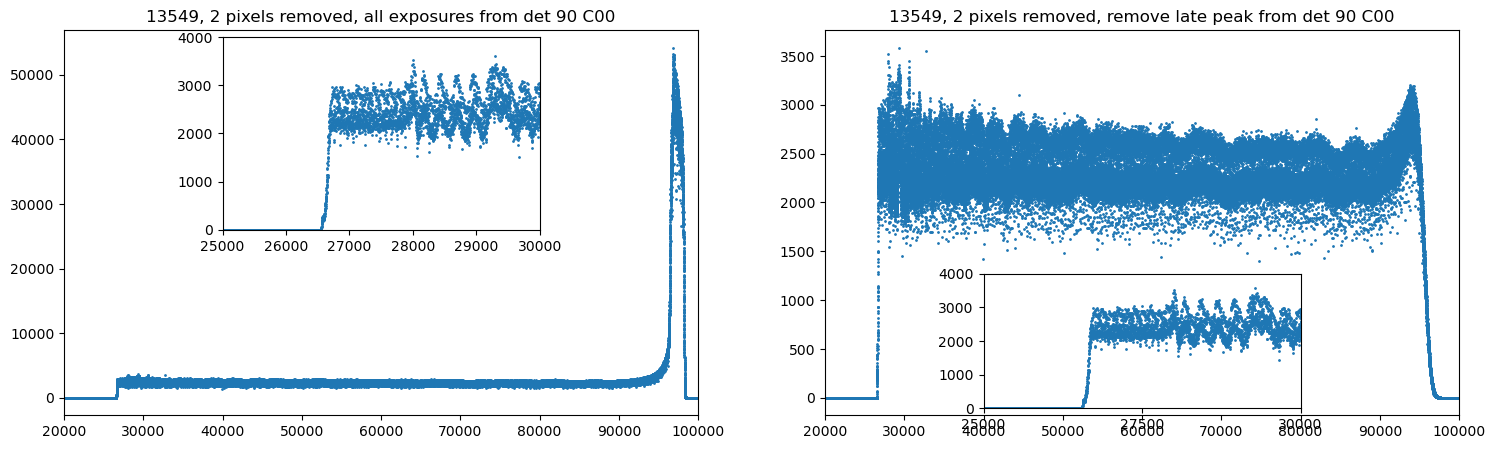

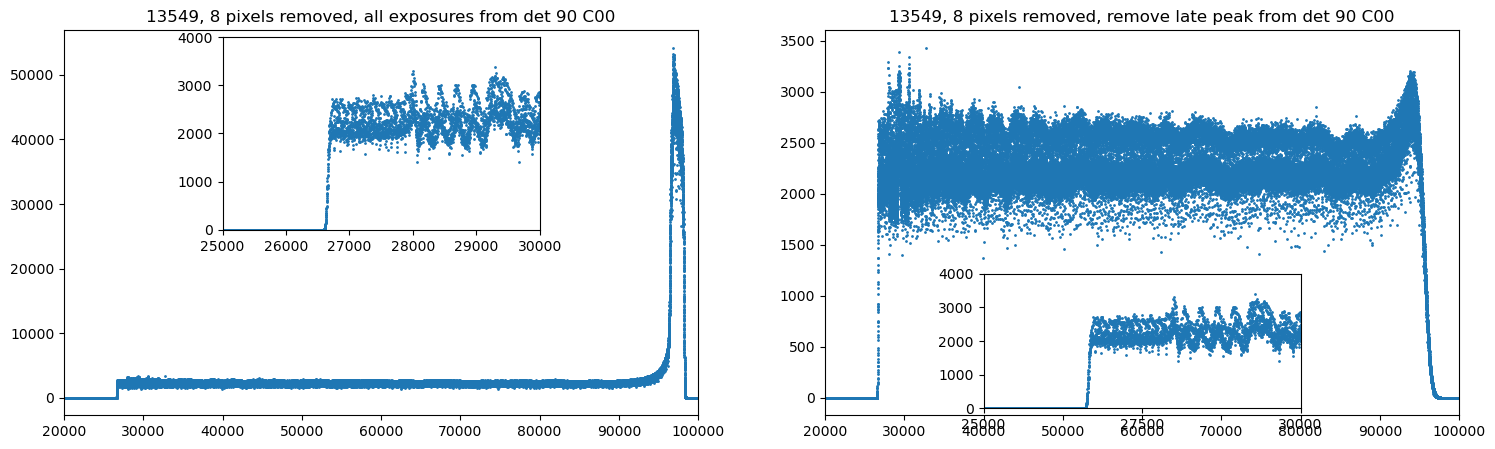

In [38]:

npixs = [0, 2, 8]
amp = 'C00' 

for npix in npixs:     
    ## images removed 
    filename = f'{npix}pixelsr90.pkl'
    directory = '/home/r/rejnicho/'
    fullfilename = os.path.join(directory, filename)
    
    with open(fullfilename, 'rb') as f:
        fulldict = pkl.load(f) 

    counts = fulldict[amp]
    bins = np.arange(2e4, 2e5)

    ## all images 
    filename = f'remove{npix}pixelsfromedge90.pkl'
    directory = '/home/r/rejnicho/'
    fullfilename = os.path.join(directory, filename)
    with open(fullfilename, 'rb') as f:
        countsdictionary = pkl.load(f) 

    allcounts = countsdictionary[amp]

    fig, axs = plt.subplots(1,2, figsize=(18, 5))

    if npix == 0: 
        locationRemovedExposures = "upper center" 

    else:
        locationRemovedExposures = "lower center"

    axs[1].scatter(bins[:len(counts)], counts, s=1)
    axs[1].set_title(f'13549, {npix} pixels removed, remove late peak from det 90 {amp}')
    axs[1].set_xlim(20000, 100000)

    axins2 = inset_axes(axs[1], width="50%", height="35%", loc=locationRemovedExposures)
    axins2.scatter(bins[:len(counts)], counts, s=1)
    axins2.set_xlim(25000, 30000)
    axins2.set_xticks([25000, 27500, 30000])
    axins2.set_ylim(0, 4000)

    axs[0].scatter(bins[:len(allcounts)], allcounts, s=1)
    axs[0].set_title(f'13549, {npix} pixels removed, all exposures from det 90 {amp}')
    axs[0].set_xlim(20000, 100000)

    axins1 = inset_axes(axs[0], width="50%", height="50%", loc='upper center')
    axins1.scatter(bins[:len(allcounts)], allcounts, s=1)
    axins1.set_xlim(25000, 30000)
    axins1.set_ylim(0, 4000)

    plt.show()

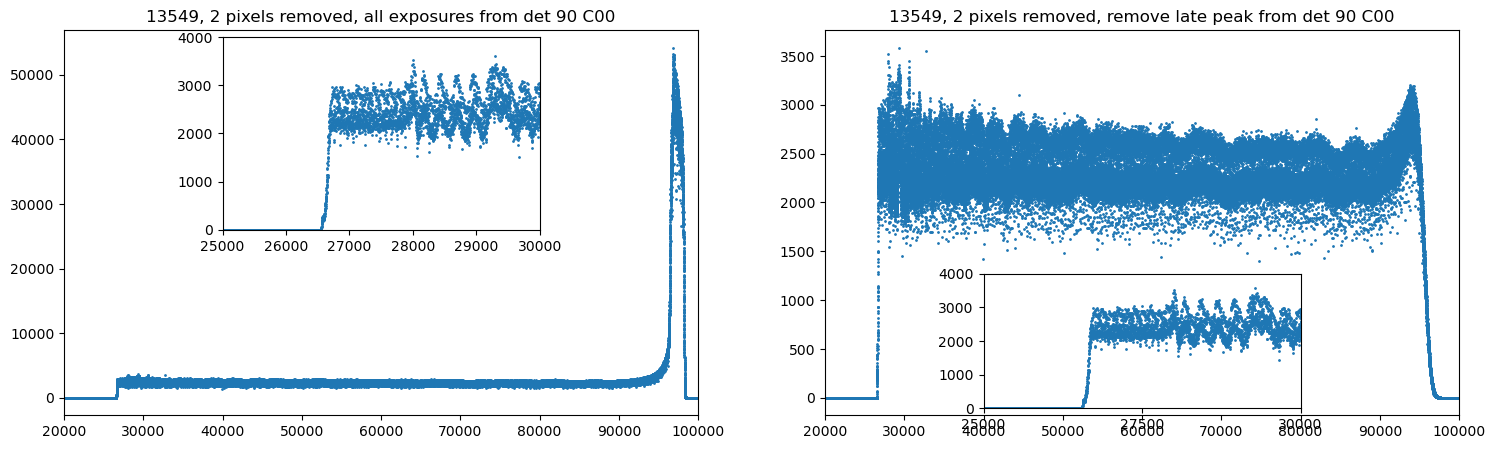

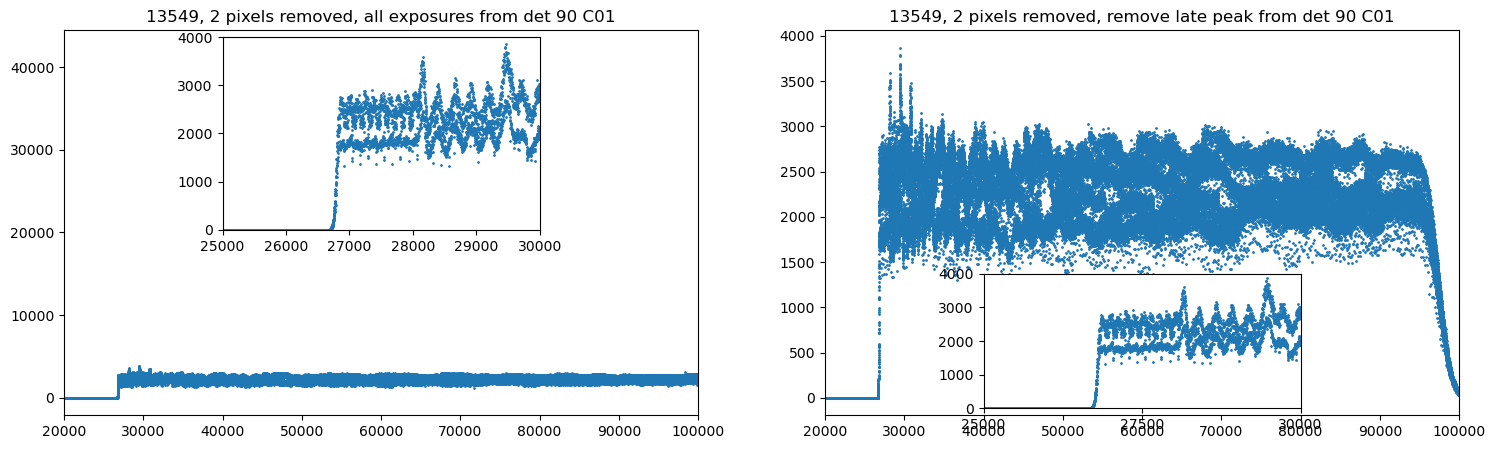

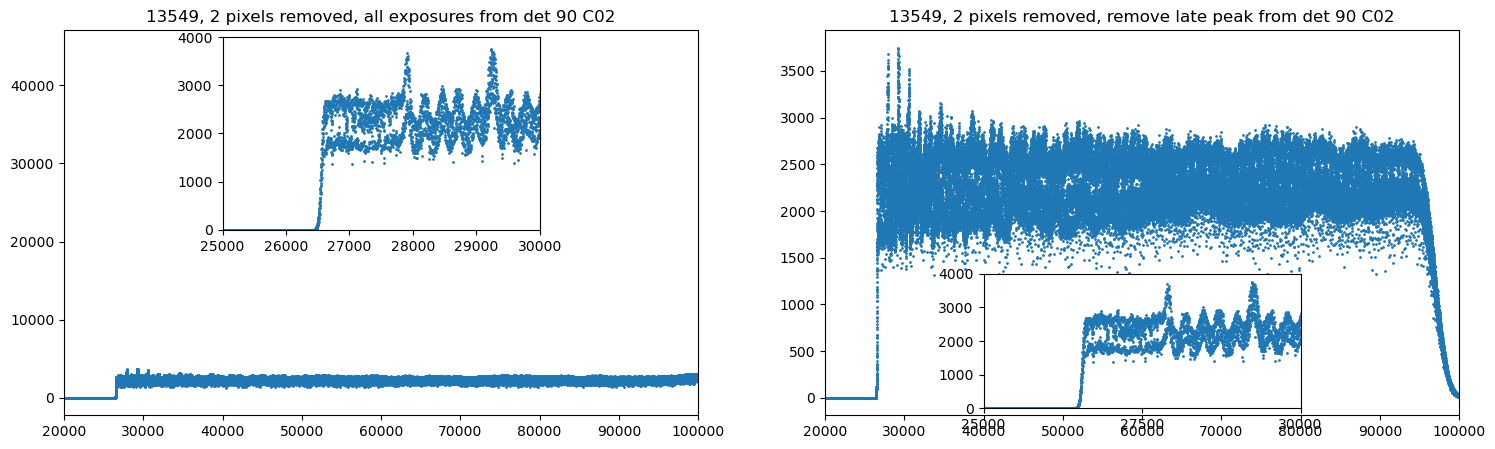

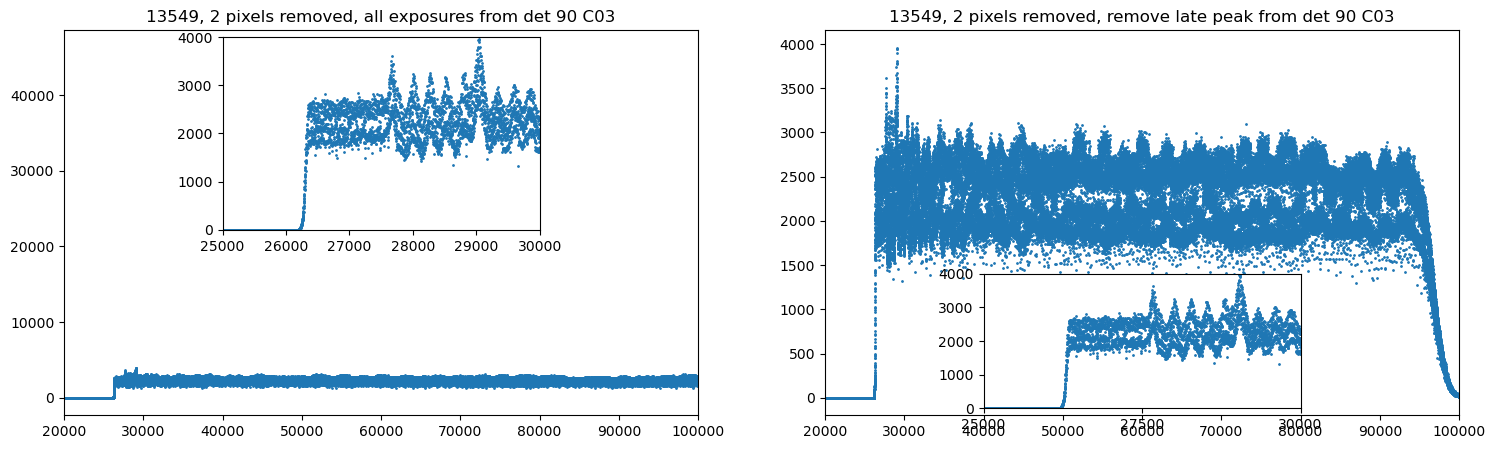

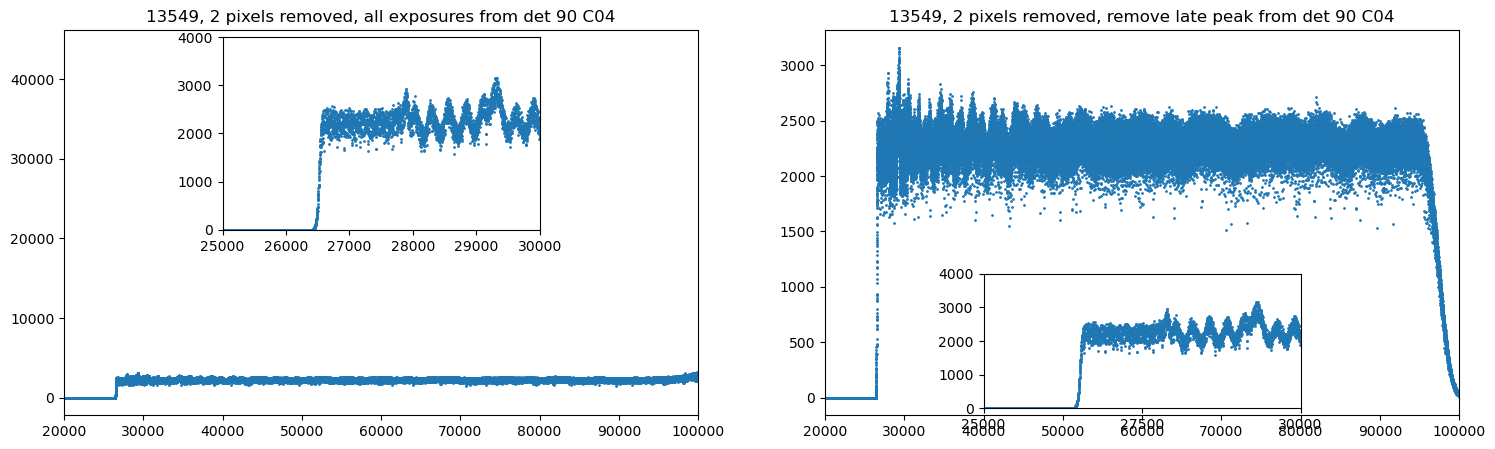

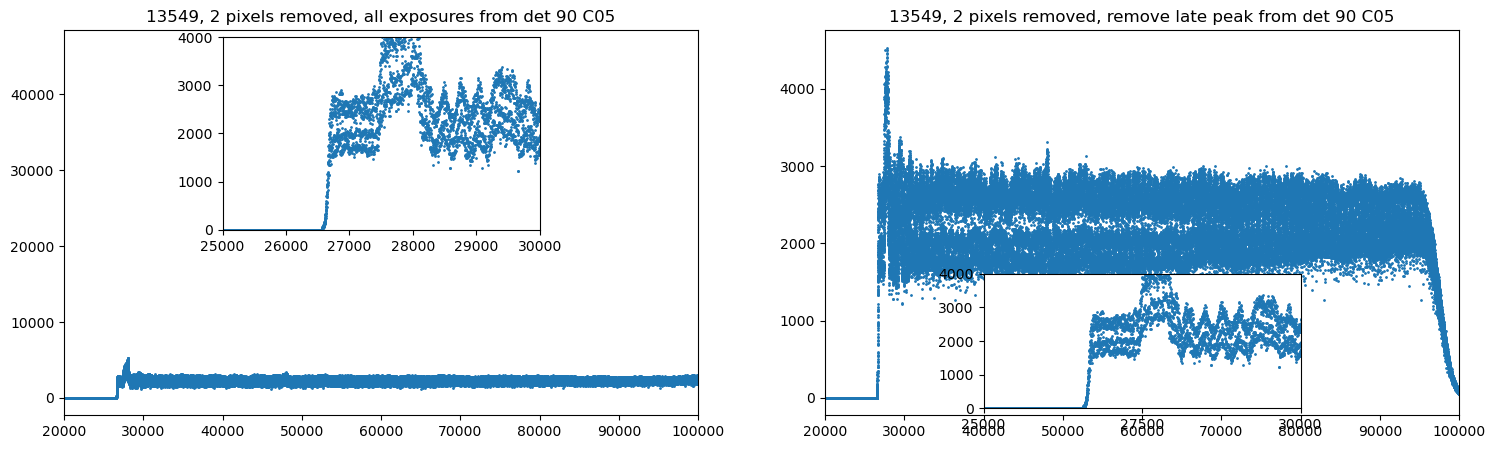

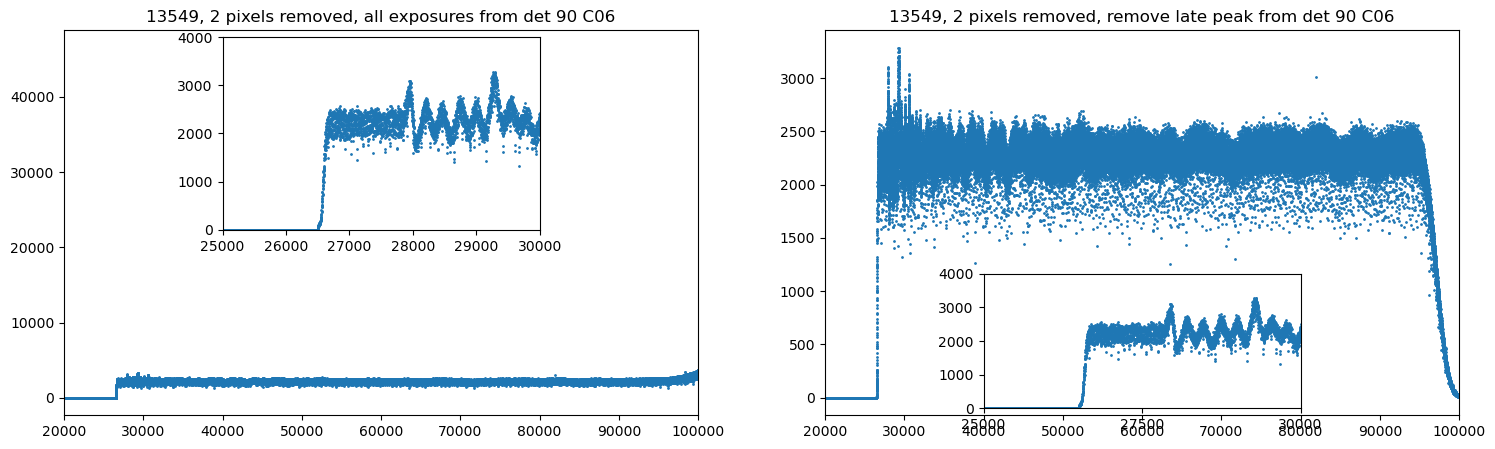

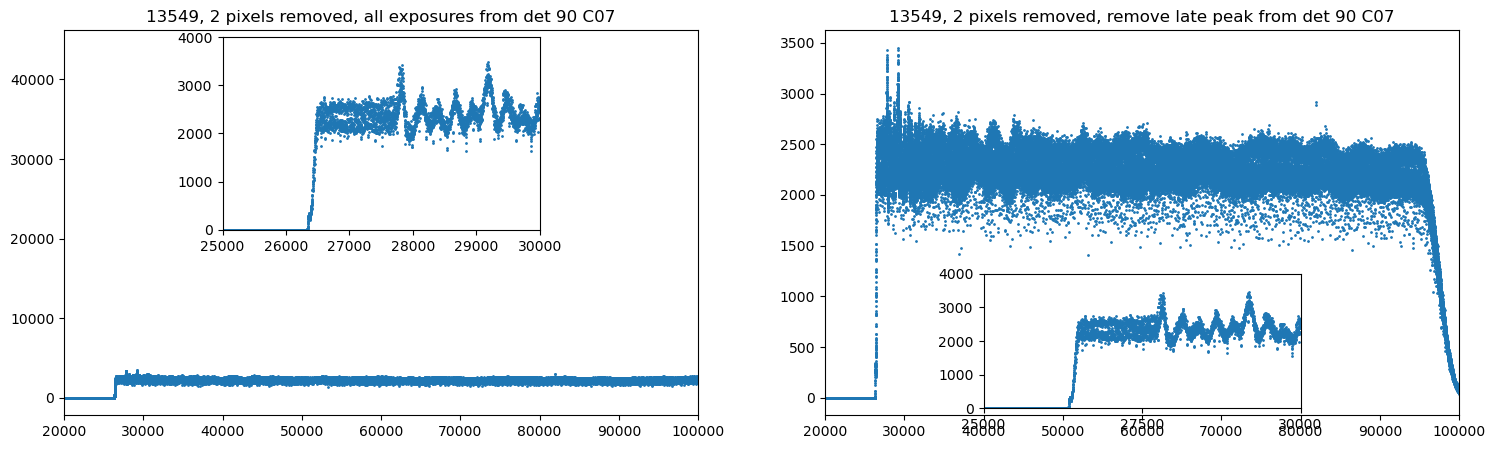

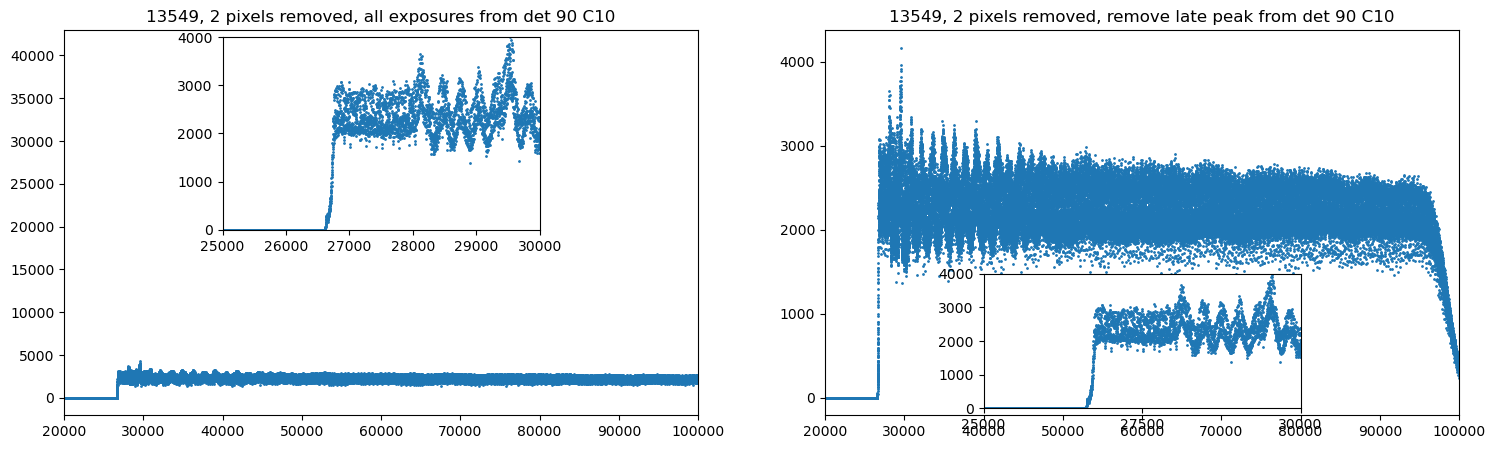

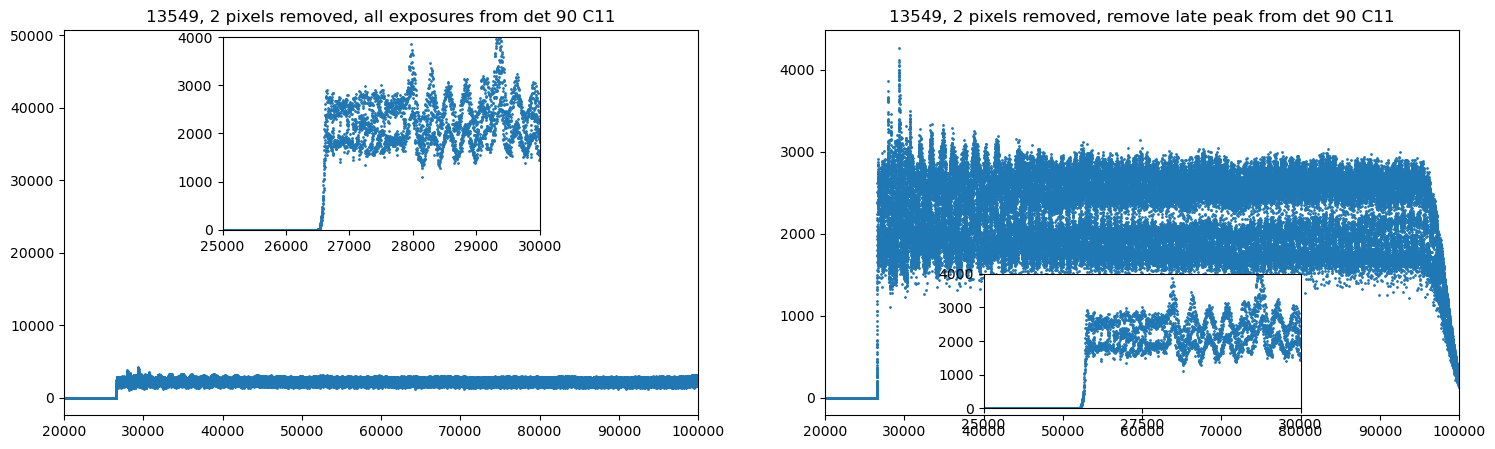

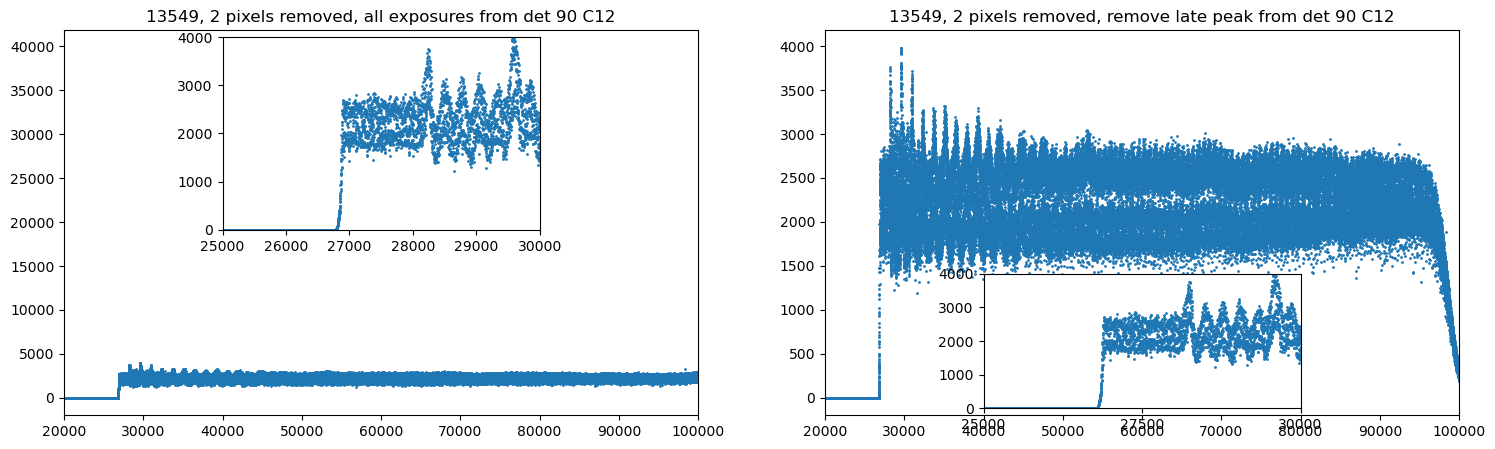

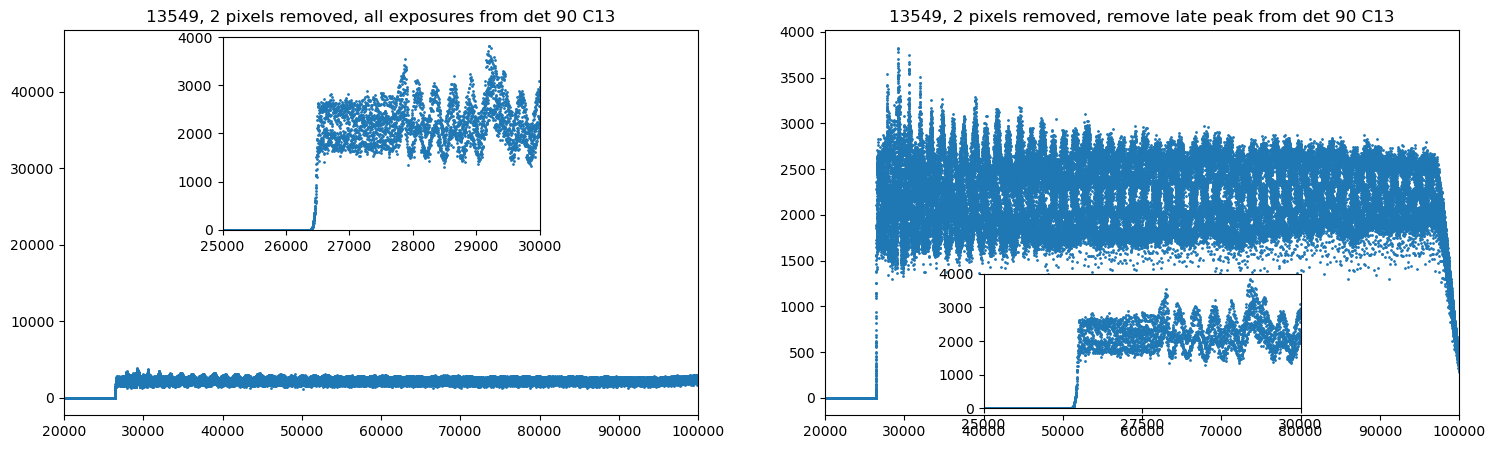

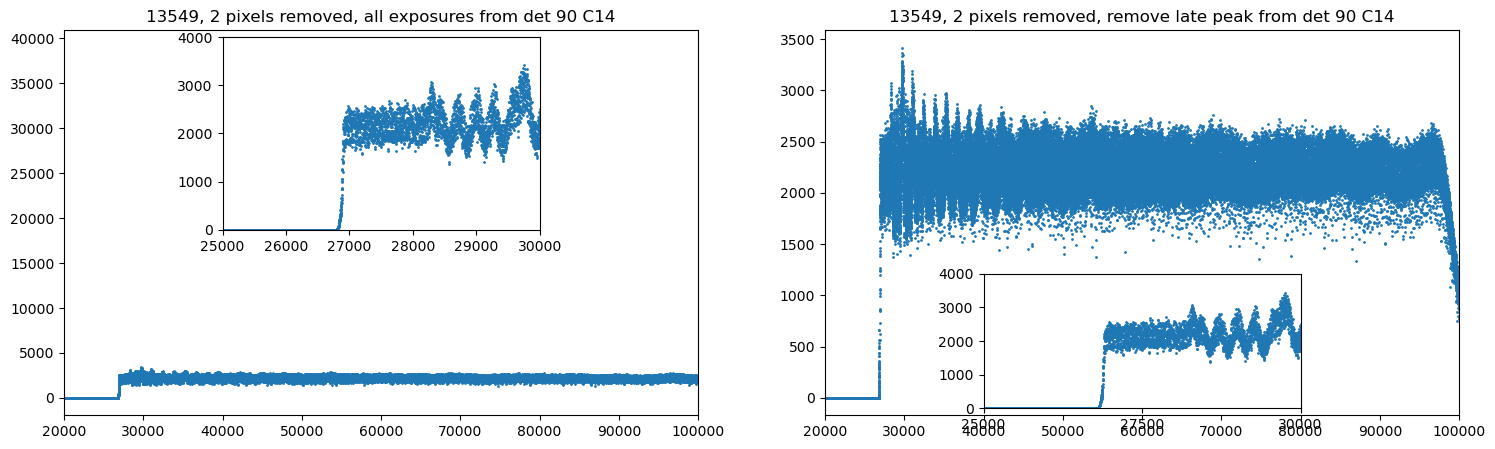

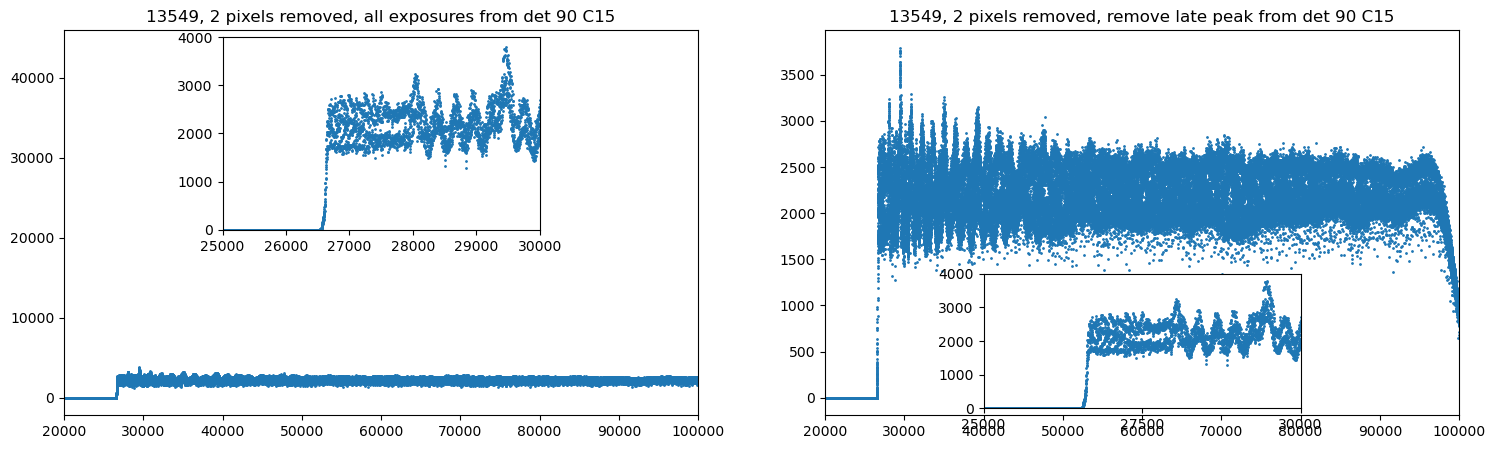

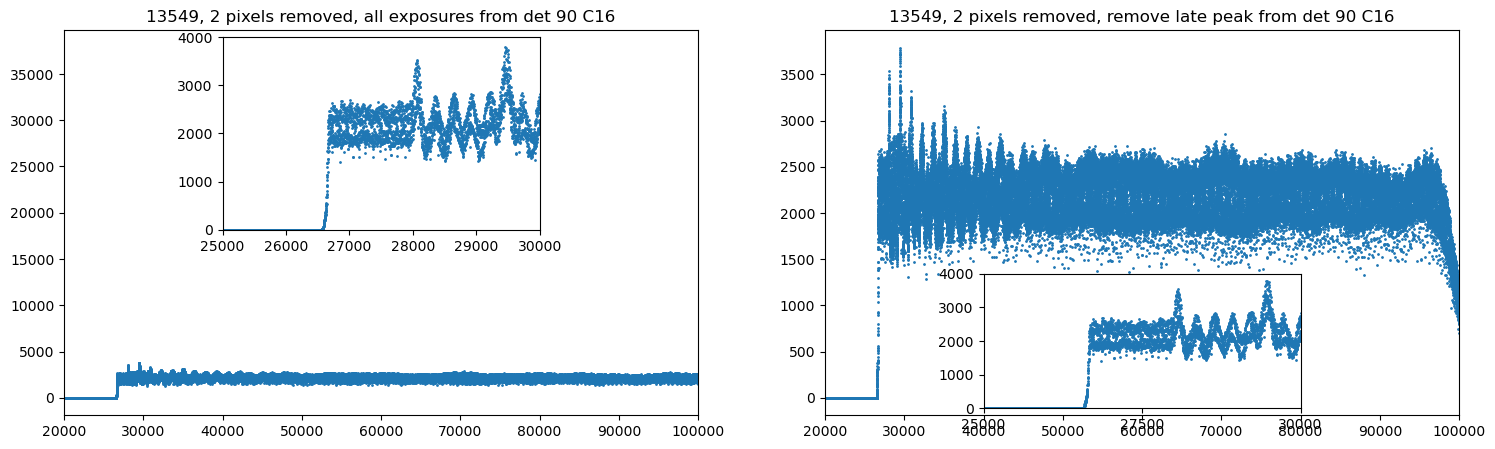

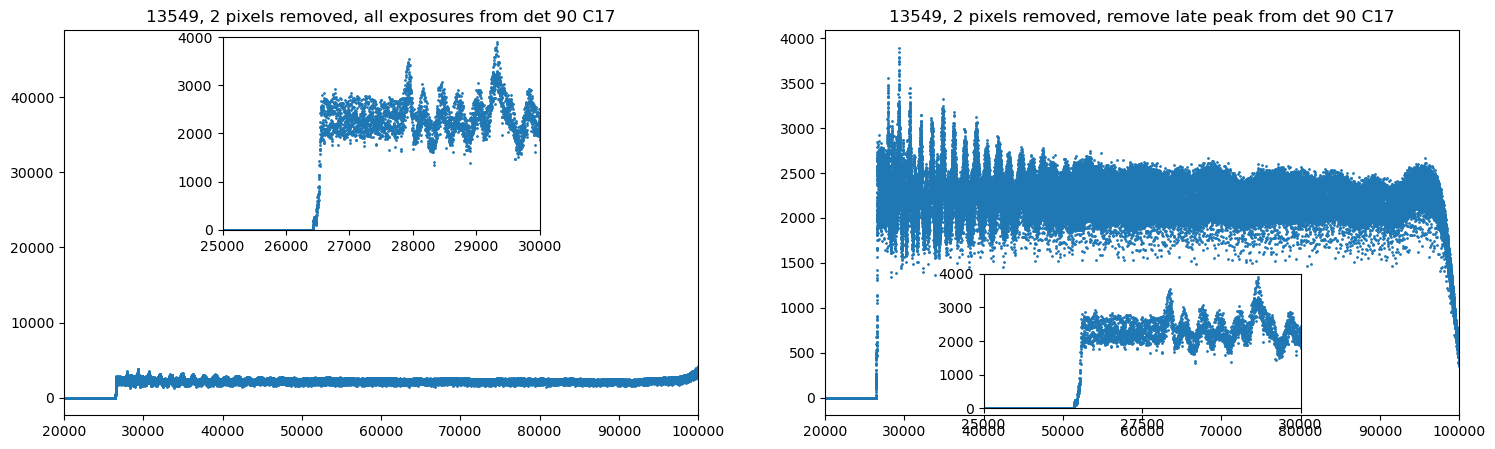

In [45]:
# check all the amps 

amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
npix = 2

for amp in amps_list:     
    ## images removed 
    filename = f'{npix}pixelsr90.pkl'
    directory = '/home/r/rejnicho/'
    fullfilename = os.path.join(directory, filename)
    
    with open(fullfilename, 'rb') as f:
        fulldict = pkl.load(f) 

    counts = fulldict[amp]
    bins = np.arange(2e4, 2e5)

    ## all images 
    filename = f'remove{npix}pixelsfromedge90.pkl'
    directory = '/home/r/rejnicho/'
    fullfilename = os.path.join(directory, filename)
    with open(fullfilename, 'rb') as f:
        countsdictionary = pkl.load(f) 

    allcounts = countsdictionary[amp]

    fig, axs = plt.subplots(1,2, figsize=(18, 5))

   
    locationRemovedExposures = "lower center"

    axs[1].scatter(bins[:len(counts)], counts, s=1)
    axs[1].set_title(f'13549, {npix} pixels removed, remove late peak from det 90 {amp}')
    axs[1].set_xlim(20000, 100000)

    axins2 = inset_axes(axs[1], width="50%", height="35%", loc=locationRemovedExposures)
    axins2.scatter(bins[:len(counts)], counts, s=1)
    axins2.set_xlim(25000, 30000)
    axins2.set_xticks([25000, 27500, 30000])
    axins2.set_ylim(0, 4000)

    axs[0].scatter(bins[:len(allcounts)], allcounts, s=1)
    axs[0].set_title(f'13549, {npix} pixels removed, all exposures from det 90 {amp}')
    axs[0].set_xlim(20000, 100000)

    axins1 = inset_axes(axs[0], width="50%", height="50%", loc='upper center')
    axins1.scatter(bins[:len(allcounts)], allcounts, s=1)
    axins1.set_xlim(25000, 30000)
    axins1.set_ylim(0, 4000)

    plt.show()

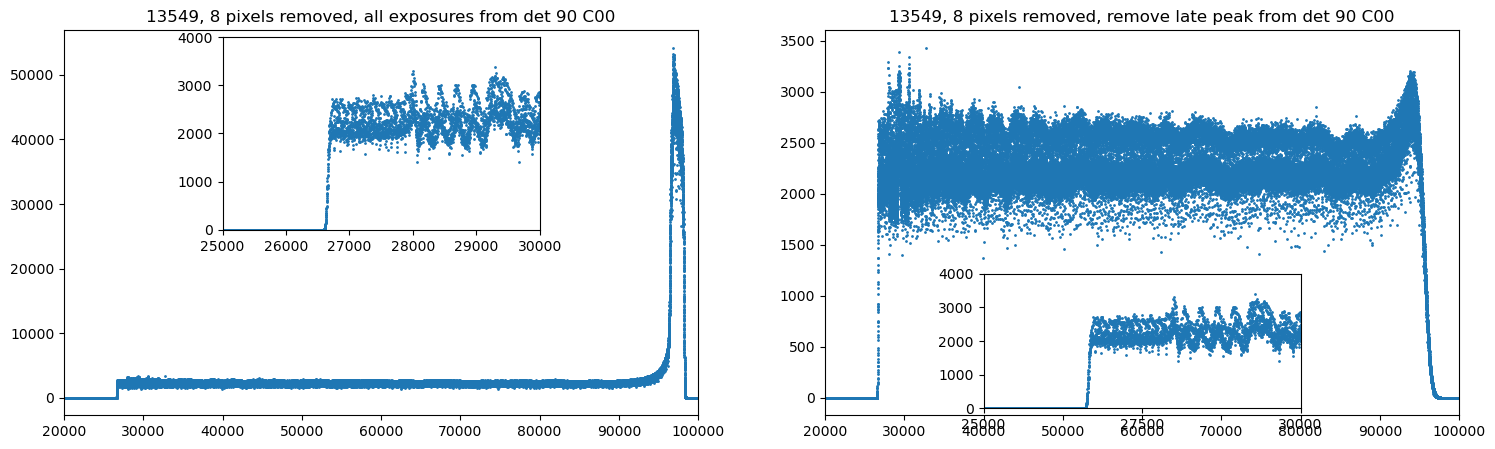

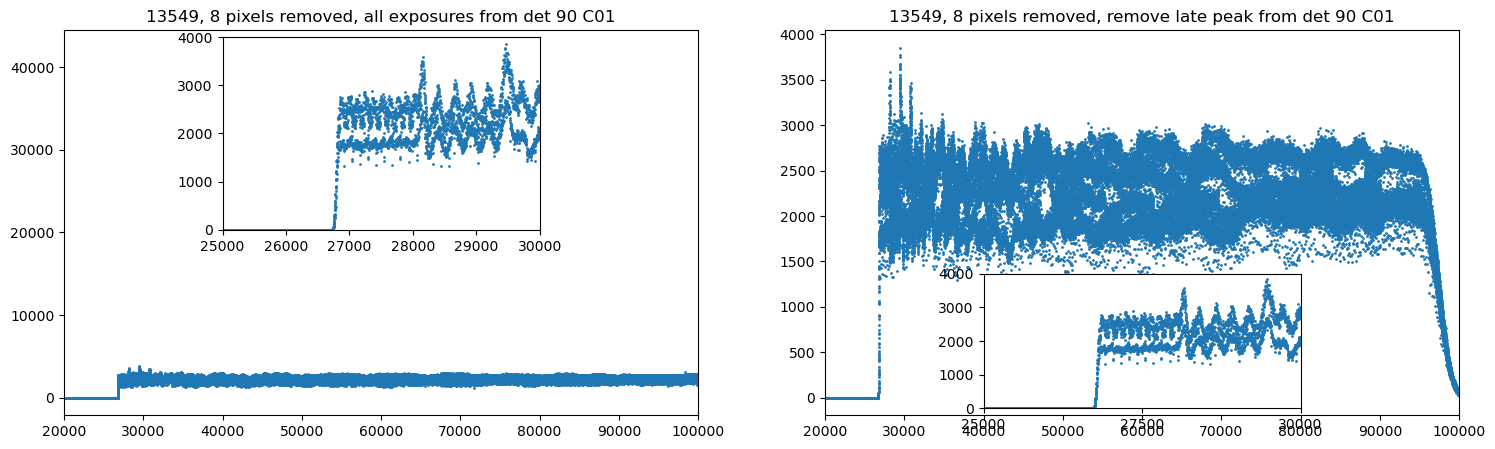

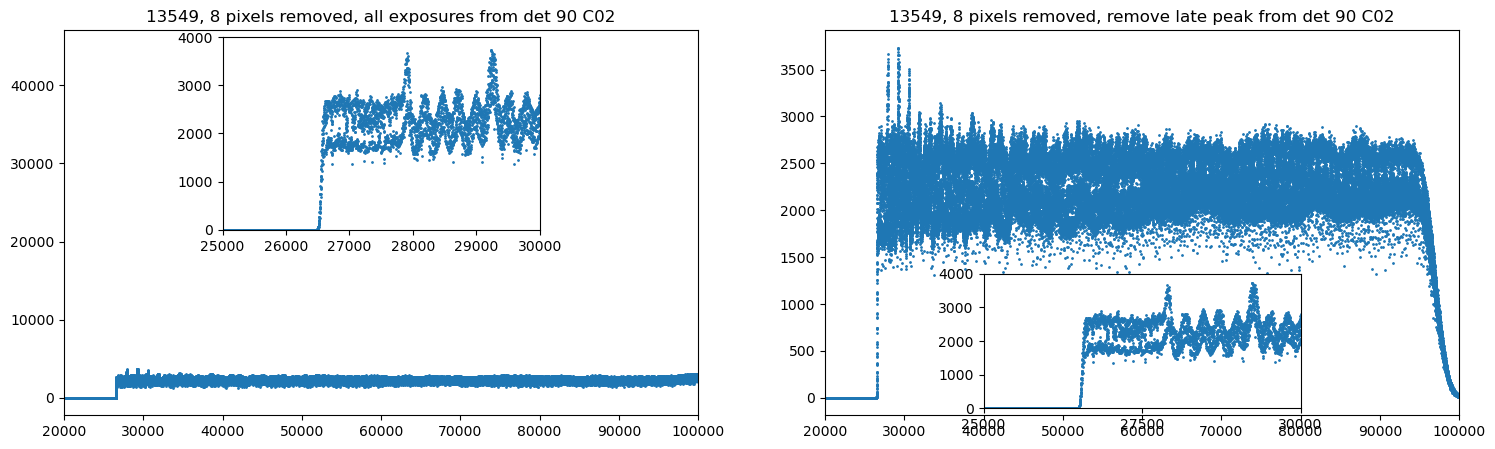

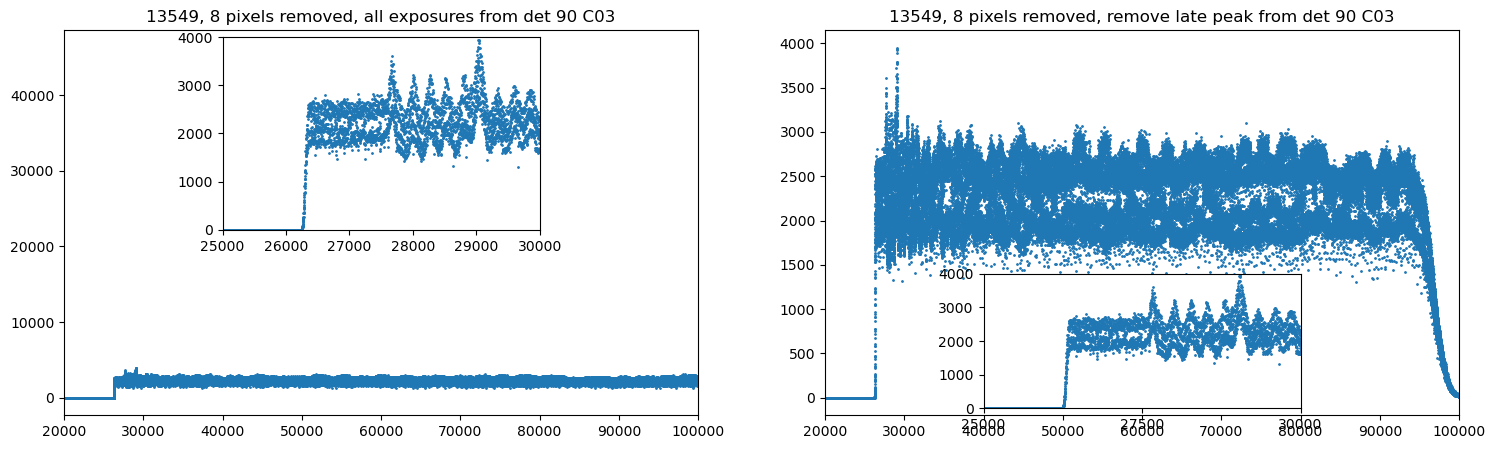

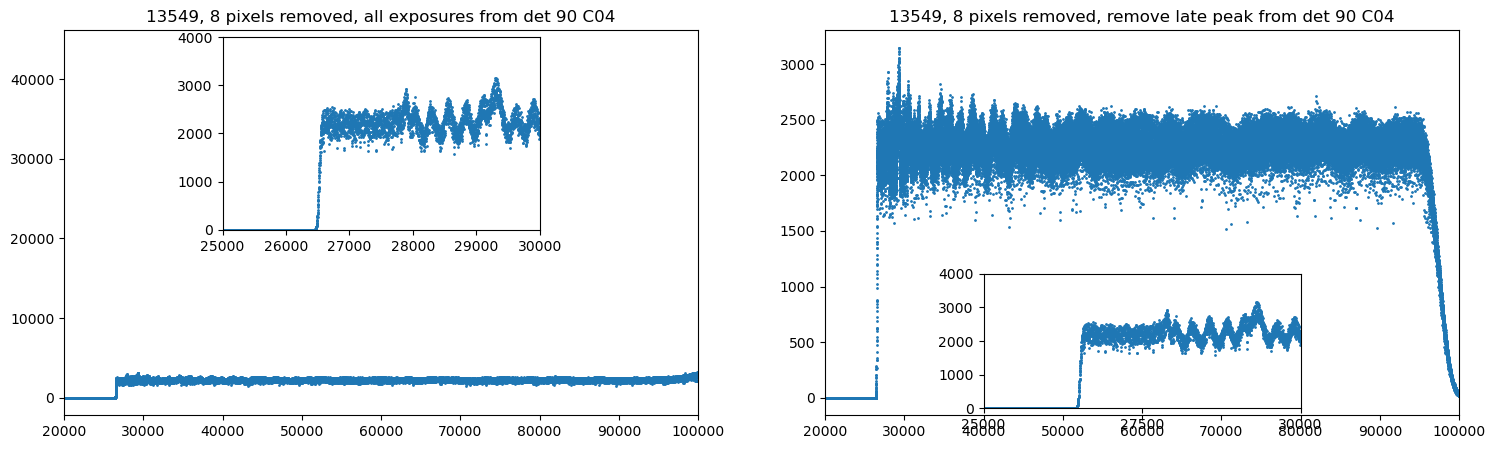

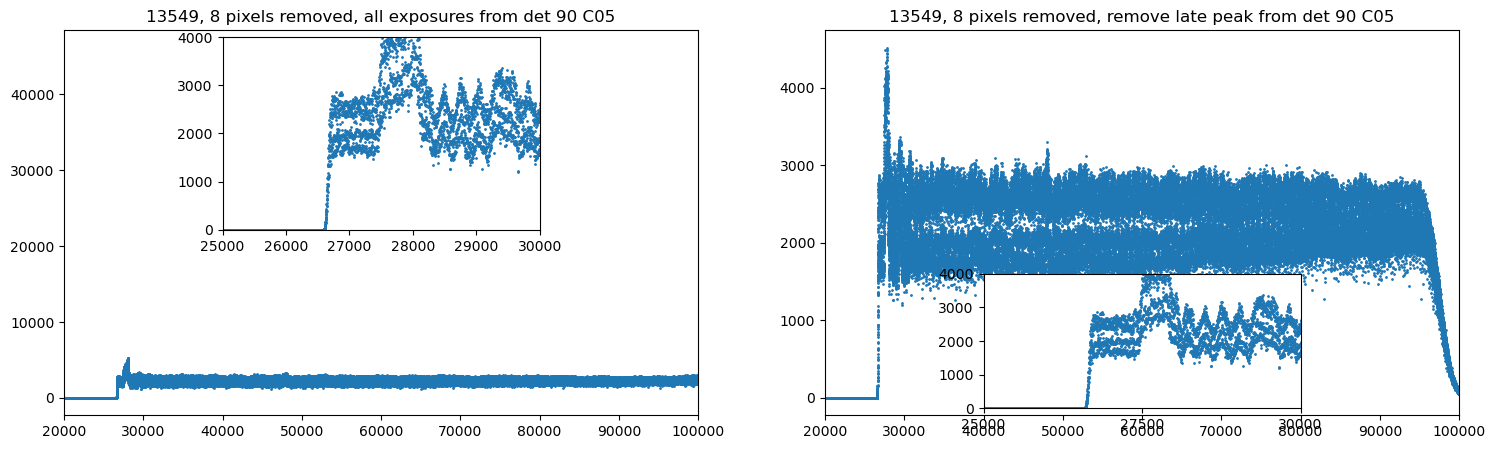

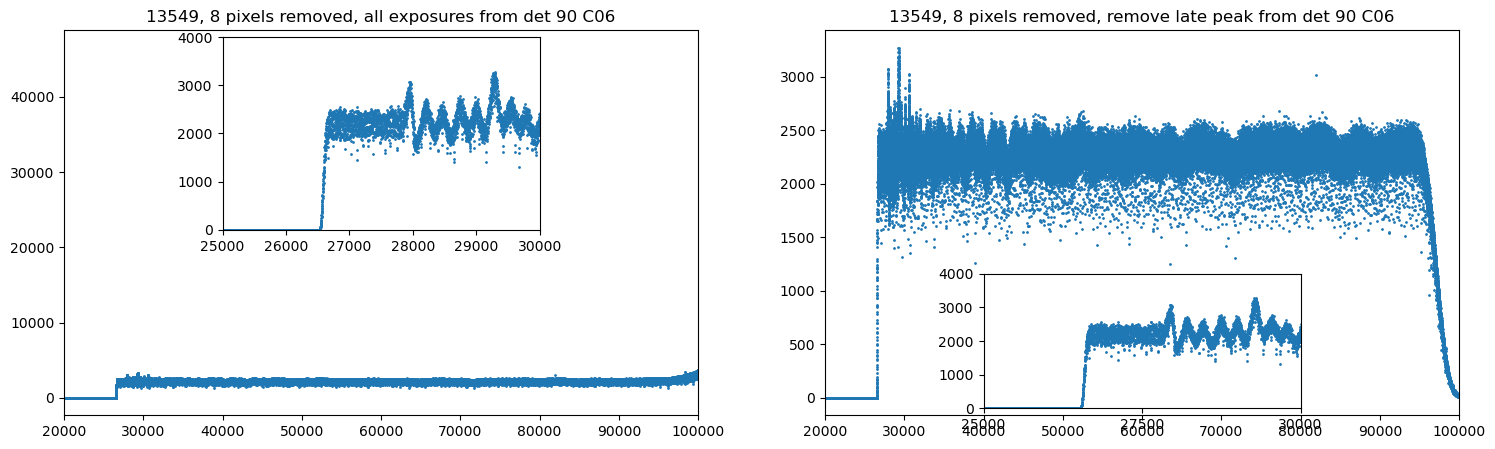

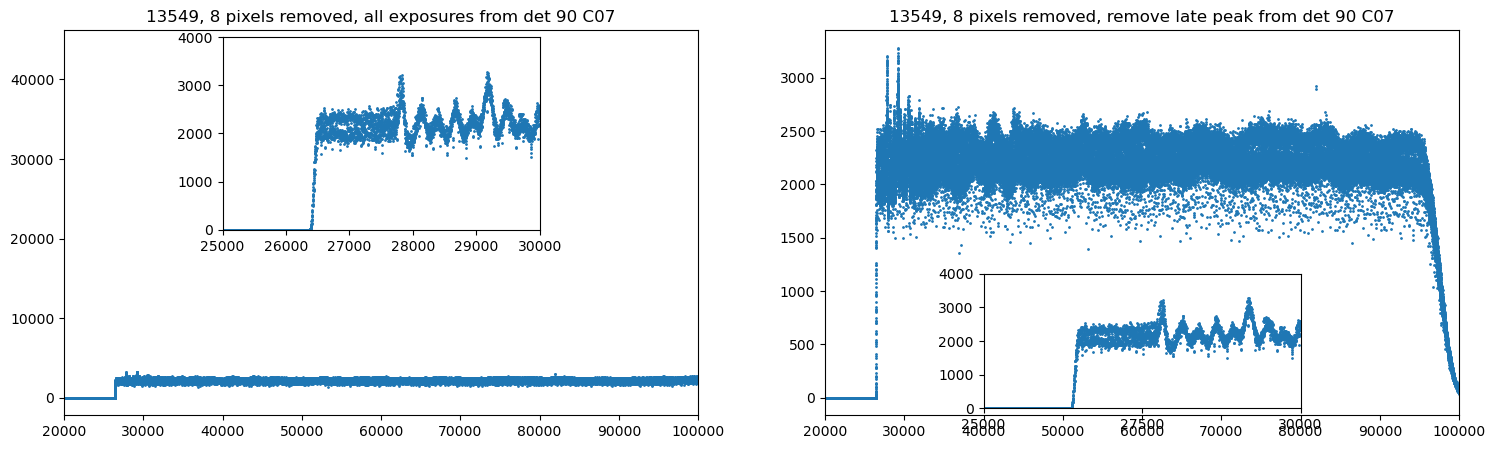

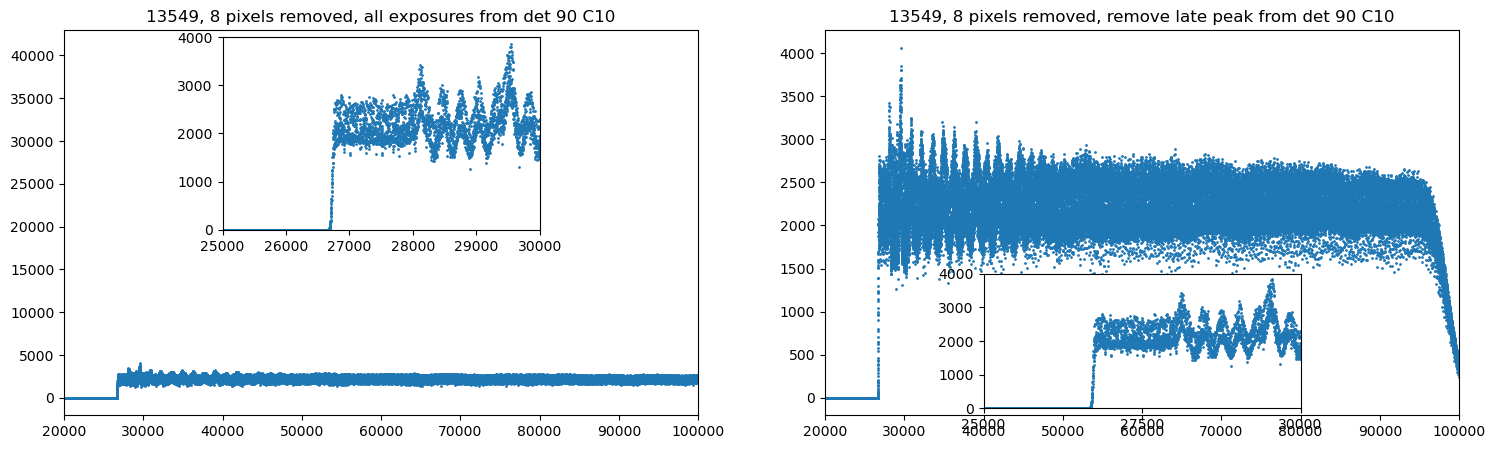

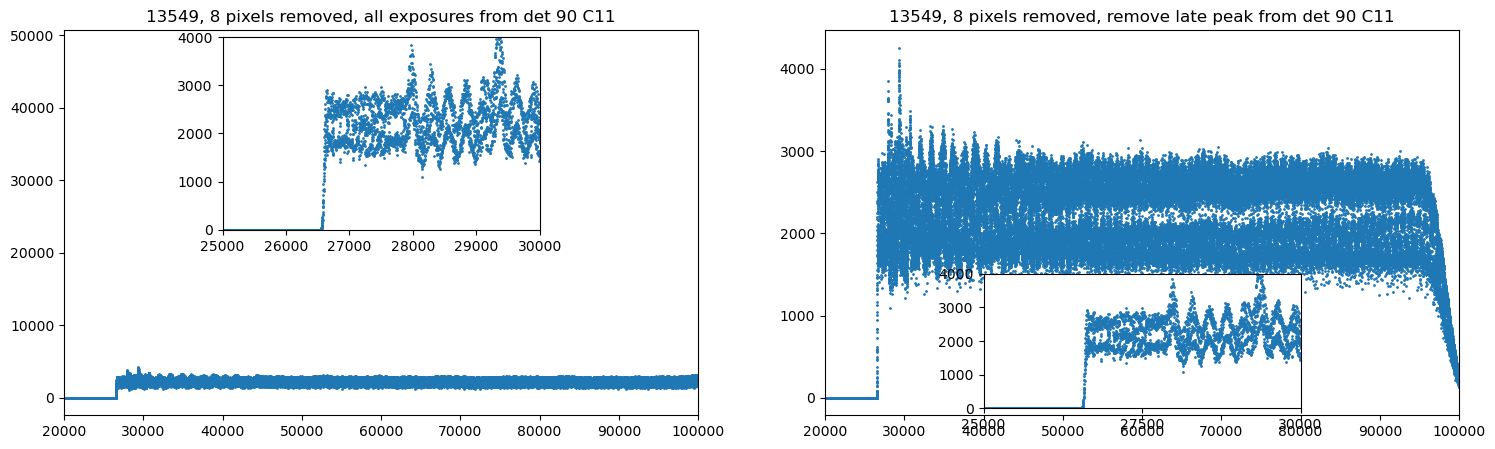

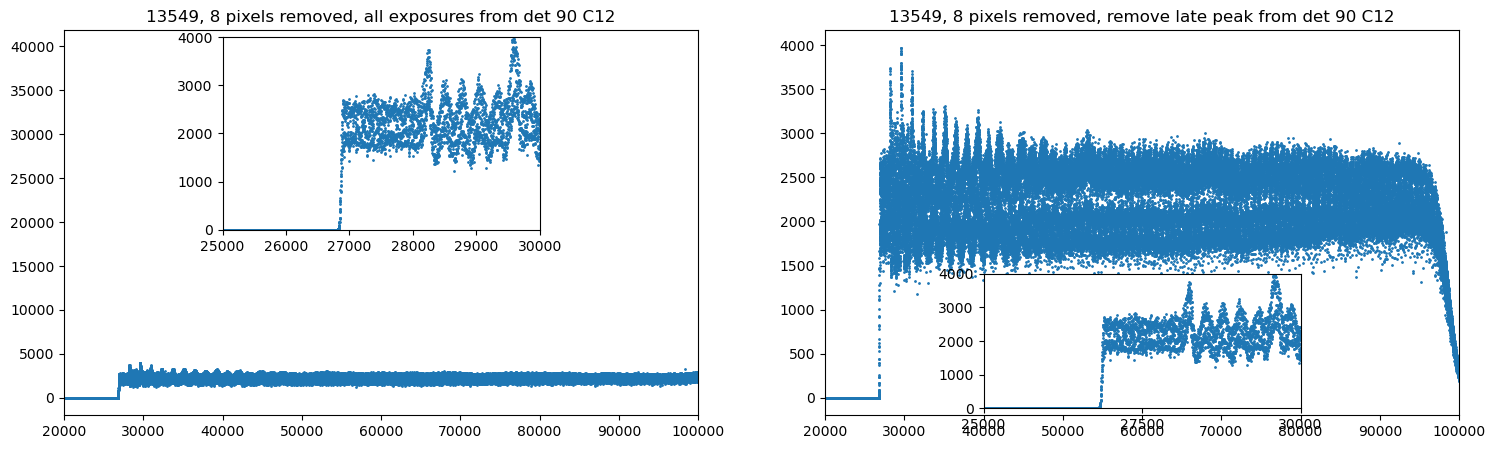

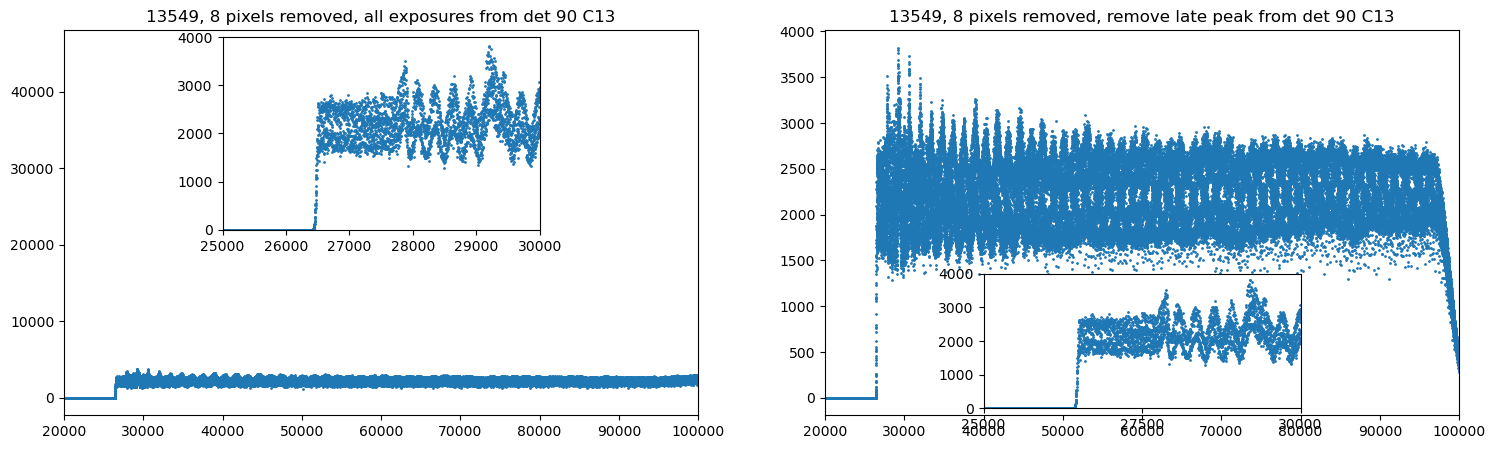

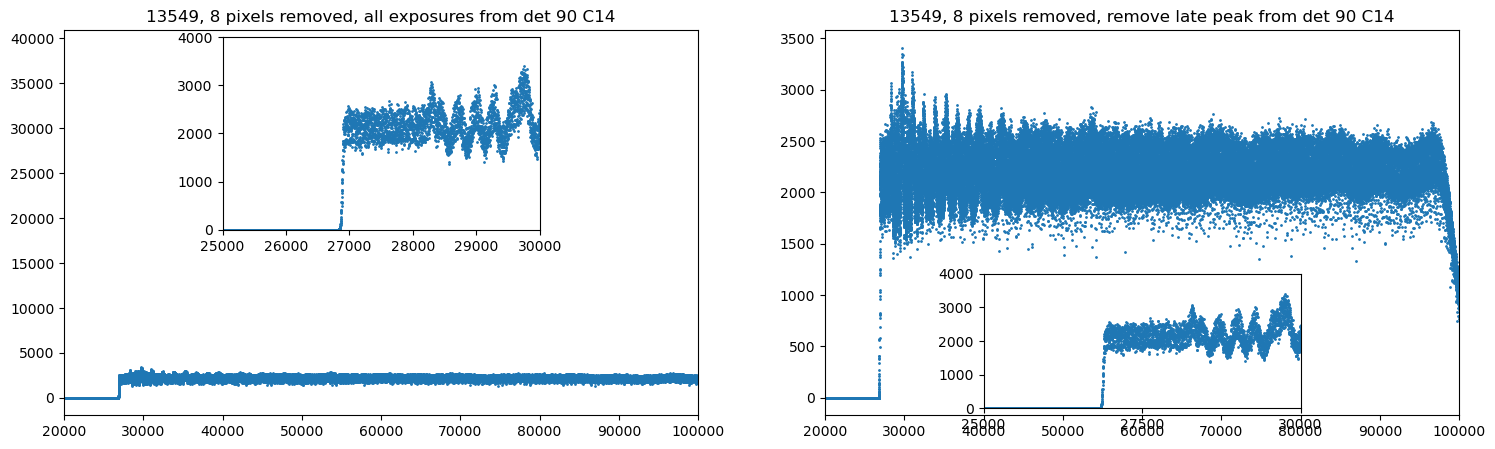

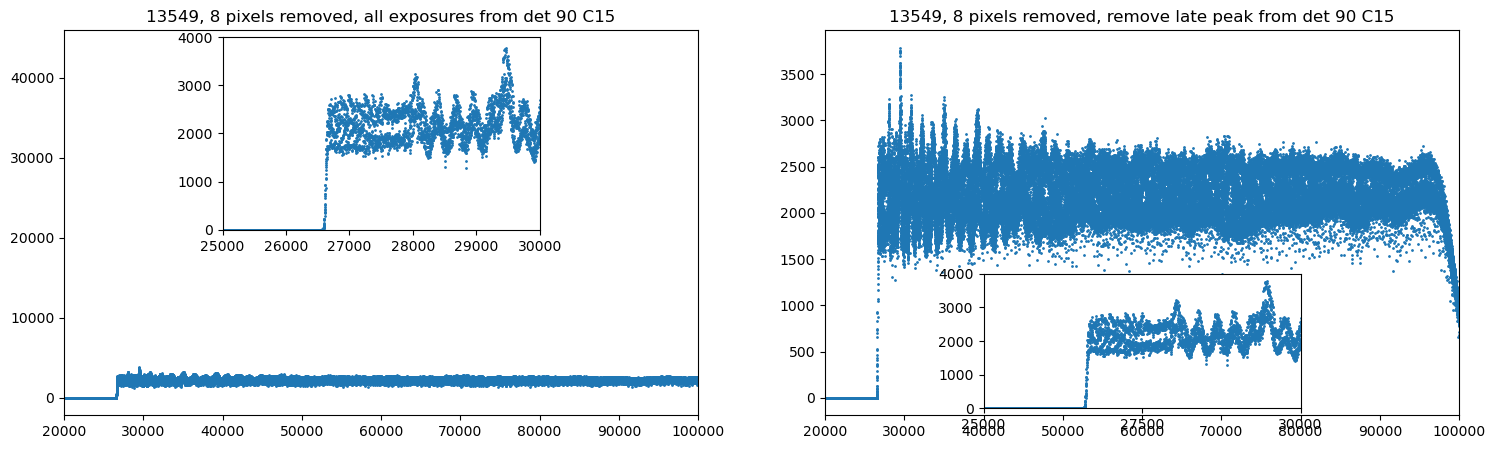

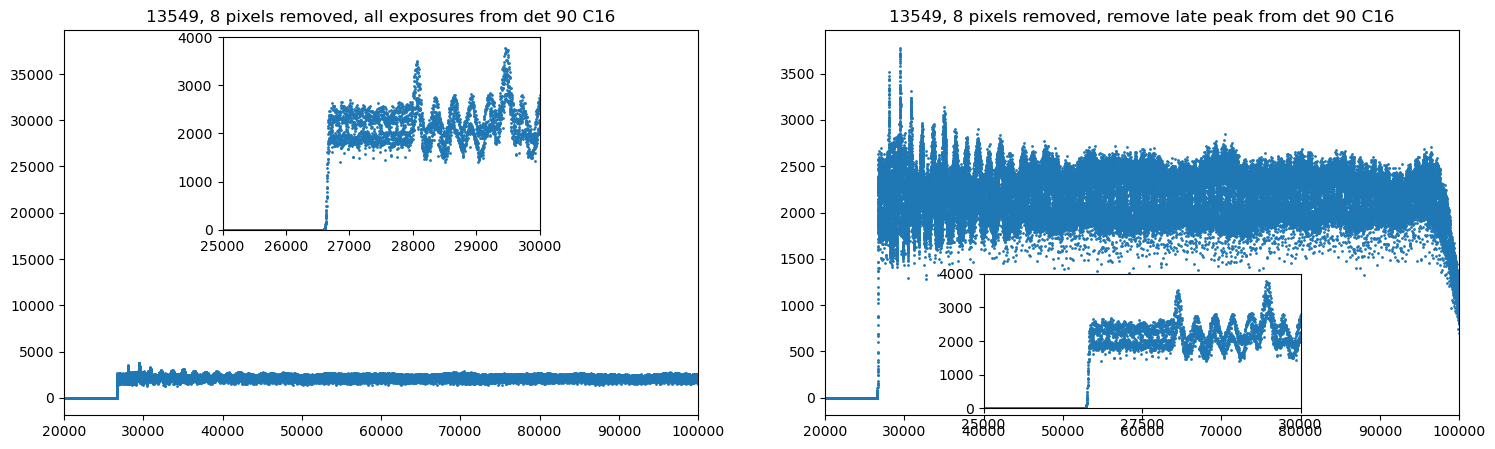

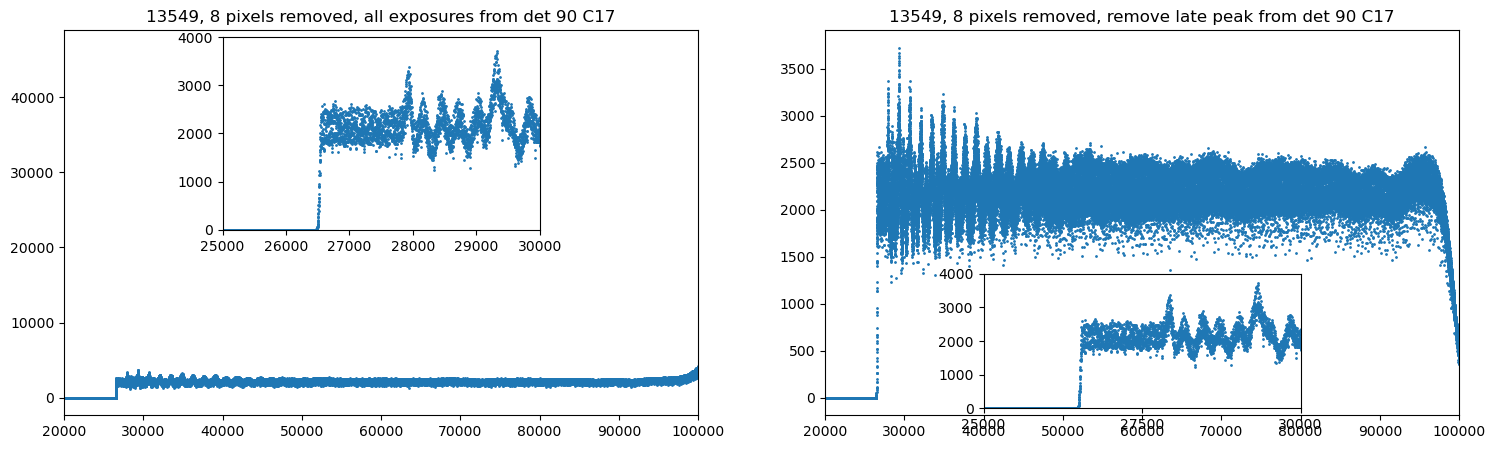

In [46]:
# check all the amps 

amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
npix = 8

for amp in amps_list:     
    ## images removed 
    filename = f'{npix}pixelsr90.pkl'
    directory = '/home/r/rejnicho/'
    fullfilename = os.path.join(directory, filename)
    
    with open(fullfilename, 'rb') as f:
        fulldict = pkl.load(f) 

    counts = fulldict[amp]
    bins = np.arange(2e4, 2e5)

    ## all images 
    filename = f'remove{npix}pixelsfromedge90.pkl'
    directory = '/home/r/rejnicho/'
    fullfilename = os.path.join(directory, filename)
    with open(fullfilename, 'rb') as f:
        countsdictionary = pkl.load(f) 

    allcounts = countsdictionary[amp]

    fig, axs = plt.subplots(1,2, figsize=(18, 5))

   
    locationRemovedExposures = "lower center"

    axs[1].scatter(bins[:len(counts)], counts, s=1)
    axs[1].set_title(f'13549, {npix} pixels removed, remove late peak from det 90 {amp}')
    axs[1].set_xlim(20000, 100000)

    axins2 = inset_axes(axs[1], width="50%", height="35%", loc=locationRemovedExposures)
    axins2.scatter(bins[:len(counts)], counts, s=1)
    axins2.set_xlim(25000, 30000)
    axins2.set_xticks([25000, 27500, 30000])
    axins2.set_ylim(0, 4000)

    axs[0].scatter(bins[:len(allcounts)], allcounts, s=1)
    axs[0].set_title(f'13549, {npix} pixels removed, all exposures from det 90 {amp}')
    axs[0].set_xlim(20000, 100000)

    axins1 = inset_axes(axs[0], width="50%", height="50%", loc='upper center')
    axins1.scatter(bins[:len(allcounts)], allcounts, s=1)
    axins1.set_xlim(25000, 30000)
    axins1.set_ylim(0, 4000)

    plt.show()